In [26]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from itertools import combinations
from scipy import stats

In [27]:
FMT = r'%d/%m/%Y'

In [28]:
file_phys = 'Y5_MP_sampling_points_data.csv'
file_metadata = 'MS_data/CSV_files/processed_csv_data_dir/meta_data.csv'
data_dir = '../../Data'

In [29]:
try: os.chdir(data_dir)
except FileNotFoundError: pass

In [30]:
df_phys = pd.read_csv(file_phys)
# df_phys

In [31]:
variables_phys = ['pH','Temperature_(C)', 'Conductivity_(uS_cm-1)', 'TDS_(mg_L-1)','TOC_(mg_L-1)','POC_(mg_C_L-1)']

In [32]:
dates = df_phys['Date'].to_numpy()

m_shape = {'HM': 'o','AM': 's',}
sitesshort = {'Auchencorth Moss':'AM', 'Hare Moss':'HM'}
seasonal_colours = {
    'Aut': '#BF5700', # burnt orange
    'Win1': '#4B61D1', # Savoy blue
    'Win2': '#4E2A84', # northwestern purple
    'Spr': '#E0B0FF', # mauve
    'Sum': '#50C878', # emerald green
}

In [33]:
def season(date:str|int,sep='-'):
    if type(date) == str and sep in date:
        month = int(date.split(sep)[1])
    else:
        month = int(date)

    if month in [9,10,11]: return 'Aut'
    elif month == 1: return 'Win1'
    elif month == 2: return 'Win2'
    elif month in [3,4,5]: return 'Spr'
    elif month in [6,7,8]: return 'Sum'

In [34]:
seasons_phys_list = []
for d in dates:
    seasons_phys_list.append(season(datetime.strptime(d, FMT).month))
seas_uniq = np.unique(seasons_phys_list)

In [35]:
df_phys['season'] = seasons_phys_list

In [36]:
seas_dict = {}
for s in seas_uniq:
    seas_dict[s] = df_phys[df_phys['season']==s]

In [37]:
sites = np.unique(df_phys['Site'])

In [38]:
def boxplot_anova(df_phys:pd.DataFrame,costant,costant_col,level_col,variable,ax:plt.Axes=None,title:str=None,
                  ylabel:str=None,xlabel:str=None,titlesize:float|int=16,labelsize:float|int=11,showmeans=False,
                  colours=[],marker='o',**kwargs):
    
    if ax == None:
        fig, ax = plt.subplots()
    
    level_unique = np.unique(df_phys[level_col].to_numpy())

    x = [df_phys[(df_phys[level_col]==l)&(df_phys[costant_col]==costant)][variable].dropna().to_numpy() for l in level_unique]

    bplot = ax.boxplot(x,tick_labels=level_unique,showmeans=showmeans,meanline=showmeans,medianprops=dict(color='k',ls='-'),
                       showfliers=False,patch_artist=True,**kwargs)
    
    if type(colours)!=list: colours=[colours]
    if colours != []:
        if len(bplot['boxes']) ==  len(colours):
            for patch, colour in zip(bplot['boxes'], colours):
                patch.set_facecolor(colour)
        else:
            for patch in bplot['boxes']:
                patch.set_facecolor(colours[0])

    for i in range(len(x)):
        if type(marker) != list: m = marker
        else: m = marker[i]
        ax.scatter([i+1]*len(x[i]),x[i],zorder=2,alpha=.5,marker=m,facecolors='none',edgecolors='k')

    if xlabel == None: xlabel = level_col
    ax.set_xlabel(xlabel,fontsize=labelsize)
    if ylabel == None: ylabel = variable
    ax.set_ylabel(ylabel,fontsize=labelsize)
    
    if title != None: ax.set_title(title,fontsize=titlesize)

    p_dict = {}
    for comb in list(combinations(range(len(x)),2)):
        p_dict[f'{level_unique[comb[0]]},{level_unique[comb[1]]}'] = stats.f_oneway(*[x[comb[0]],x[comb[1]]],nan_policy='omit')[1]

    p_rounding = 4
    p_str = '\n'.join([f'$p_{{{key}}}$ = {np.round(p_dict[key],p_rounding)}' for key in p_dict])
    ax.text(.91,.885,p_str,ha='left',va='top',transform=plt.gcf().transFigure)

In [39]:
sites

array(['Auchencorth Moss', 'Hare Moss'], dtype=object)

C:\Users\s2017658\AppData\Local\Temp\ipykernel_10112\3948917579.py:38: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  p_dict[f'{level_unique[comb[0]]},{level_unique[comb[1]]}'] = stats.f_oneway(*[x[comb[0]],x[comb[1]]],nan_policy='omit')[1]
C:\Users\s2017658\AppData\Local\Temp\ipykernel_10112\3948917579.py:38: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  p_dict[f'{level_unique[comb[0]]},{level_unique[comb[1]]}'] = stats.f_oneway(*[x[comb[0]],x[comb[1]]],nan_policy='omit')[1]
C:\Users\s2017658\AppData\Local\Temp\ipykernel_10112\3948917579.py:38: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  p_dict[f'{level_unique[comb[0]]},{level_unique[comb[1]]}'] = stats.f_oneway(*[x[comb[0]],x[comb[1]]],na

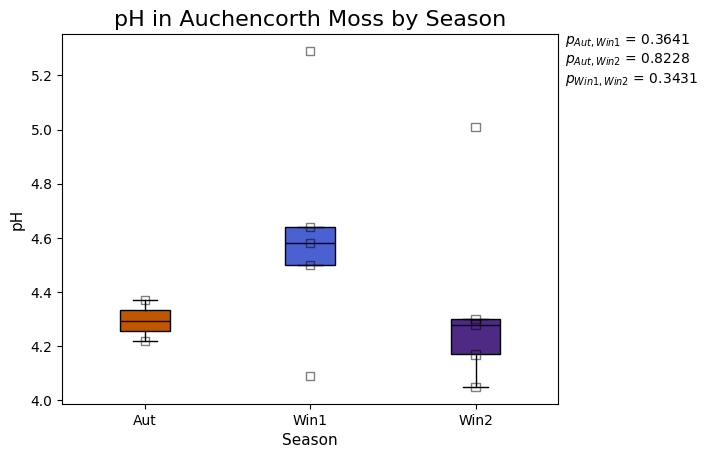

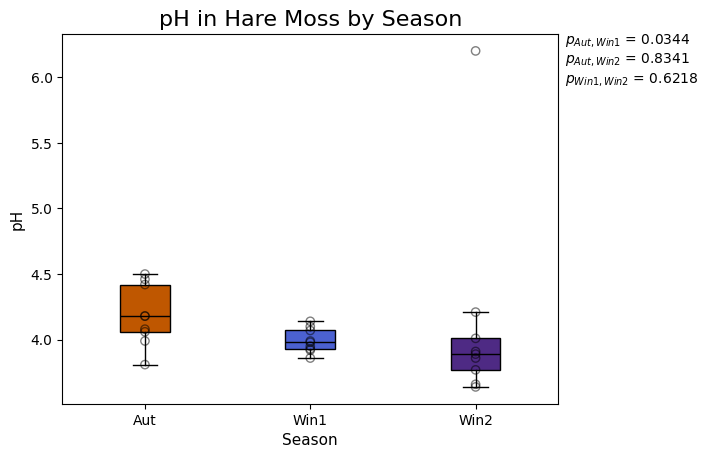

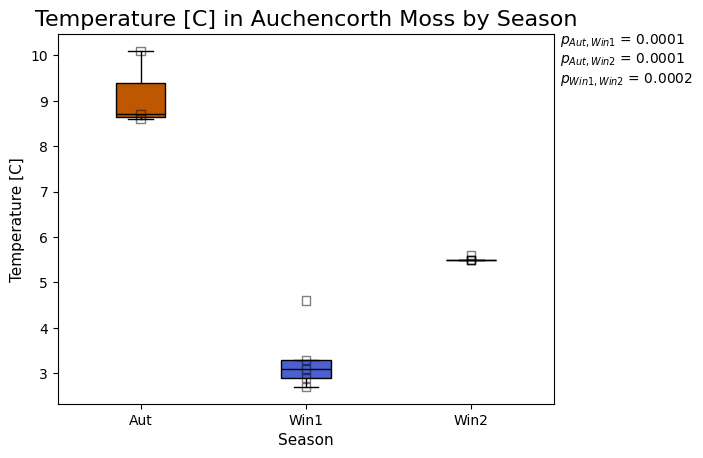

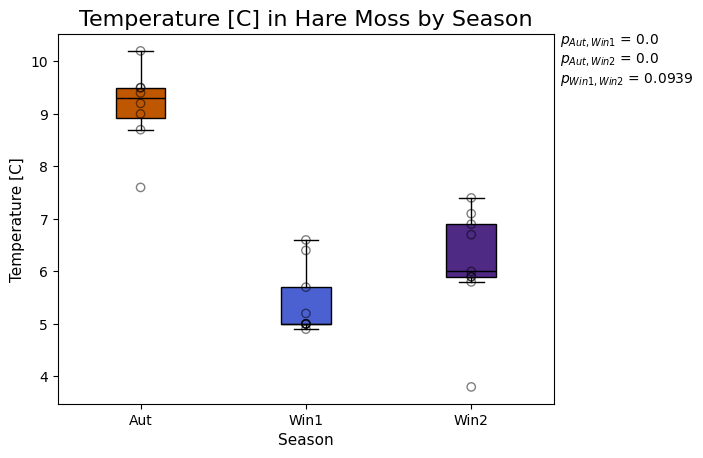

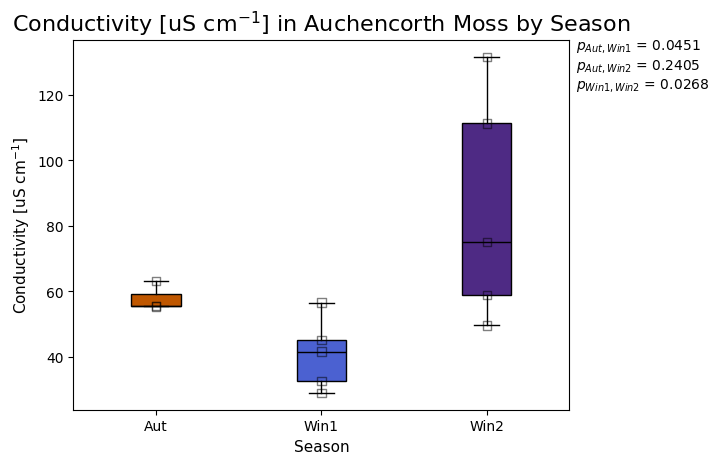

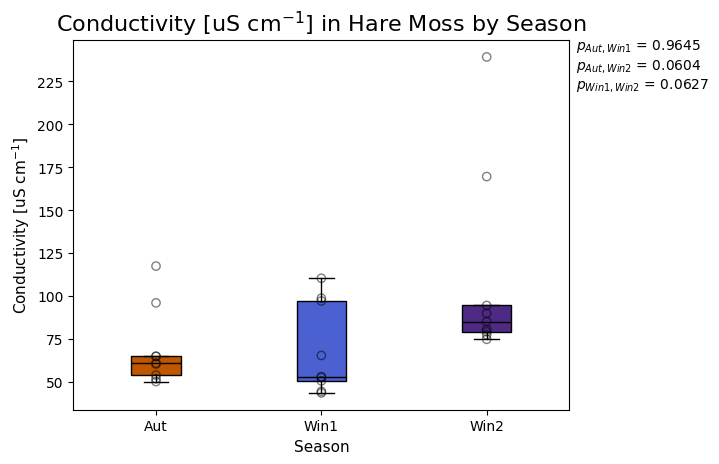

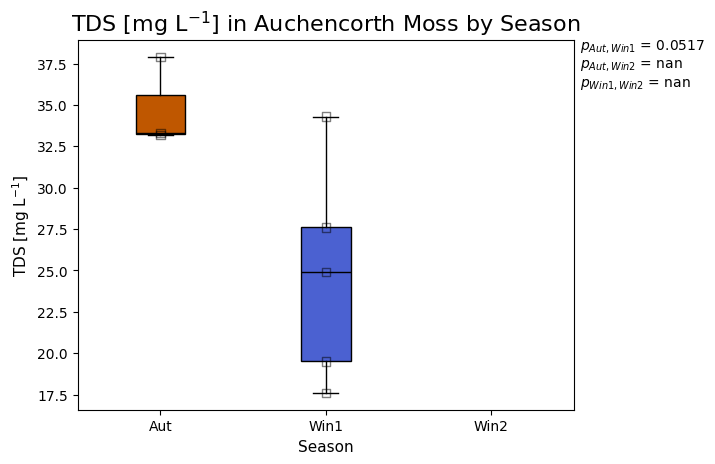

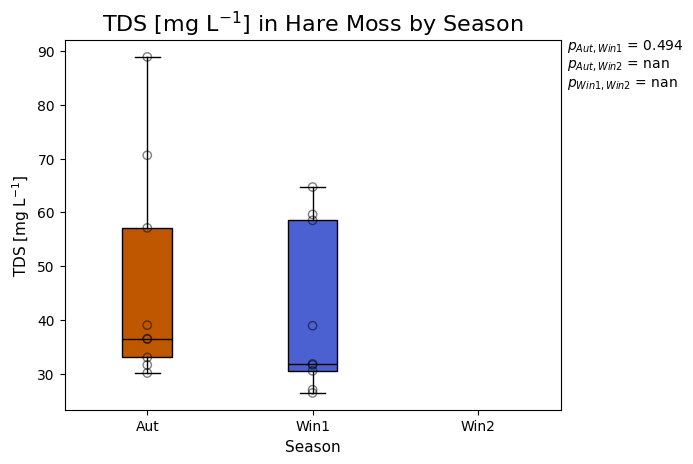

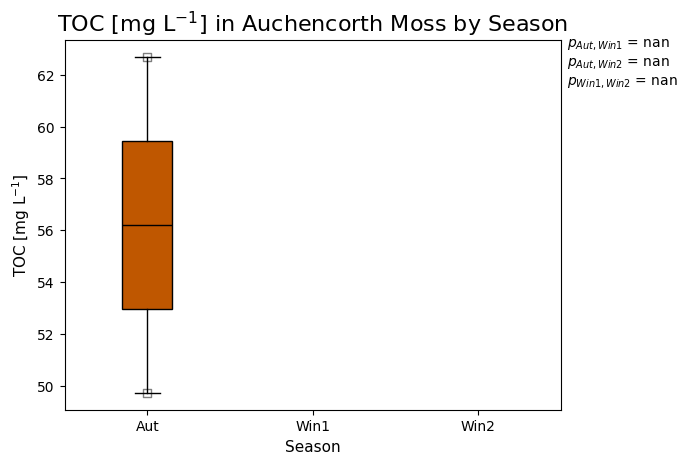

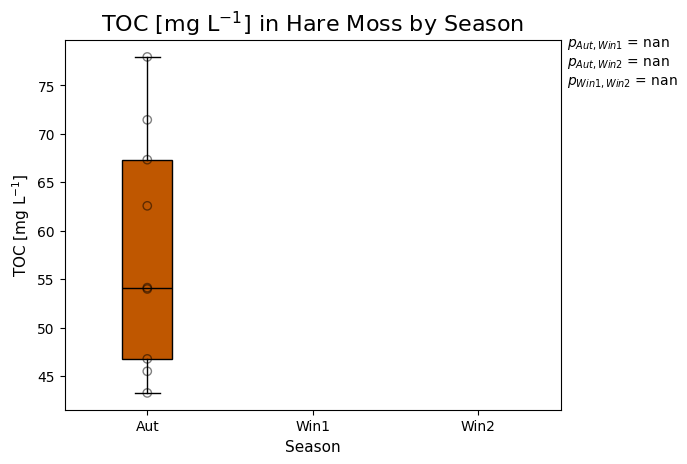

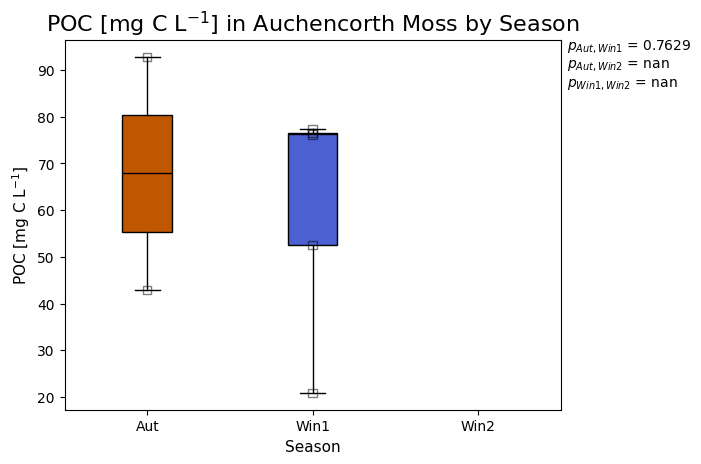

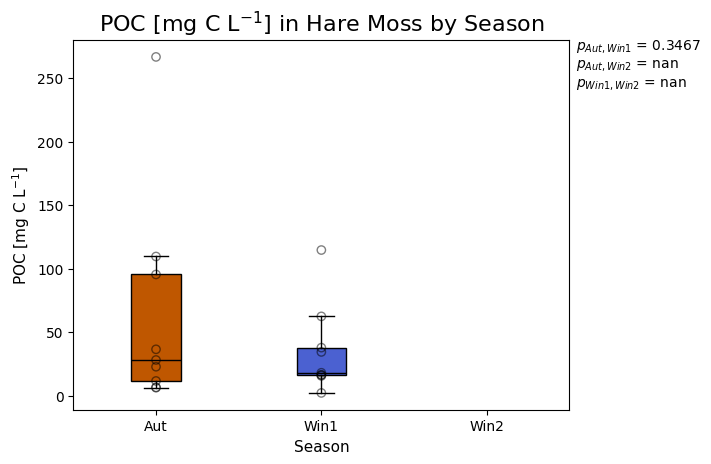

In [40]:
for v in variables_phys:
    for s in sites:
        fig_box, ax_box = plt.subplots()
        ylabel = v.replace('_',' ').replace('(','[').replace(')',']').replace('-1','$^{-1}$')
        boxplot_anova(df_phys,s,'Site','season',v,ax=ax_box,ylabel=ylabel,xlabel='Season',title=f'{ylabel} in {s} by Season',
                      colours=[seasonal_colours[s] for s in seas_uniq],marker=m_shape[sitesshort[s]])


In [41]:
df_metadata = pd.read_csv(file_metadata,)
df_metadata = df_metadata[~df_metadata['Unnamed: 0'].str.contains('SRFA')]
df_metadata = df_metadata.loc[:,(df_metadata != 0).any(axis=0)]

In [42]:
seasons_metadata_list = []
sites_metadata_list = []
for s in df_metadata['Unnamed: 0']:
    s = s.split('-')
    seasons_metadata_list.append(s[-1])
    if s[0] == 'AM':
        sites_metadata_list.append('Auchencorth Moss')
    elif s[0] == 'HM':
        sites_metadata_list.append('Hare Moss')
df_metadata['season'] = seasons_metadata_list
df_metadata['Site'] = sites_metadata_list

In [43]:
variables_metadata = list(df_metadata.columns)

In [44]:
variables_metadata.remove('Unnamed: 0')
variables_metadata.remove('season')
variables_metadata.remove('Site')

In [45]:
df_metadata

,Unnamed: 0,C,H,N,O,S,H/C,N/C,O/C,S/C,...,tannins_tot,tannins_%,amino_sugars_tot,amino_sugars_%,peptides_tot,peptides_%,unassigned_tot,unassigned_%,season,Site
0,AM-A-Aut,18.223757,25.653315,0.169890,7.172652,0.062155,1.407685,0.009322,0.393588,0.003411,...,117,16.160221,0,0.000000,8,1.104972,144,19.889503,Aut,Auchencorth Moss
1,AM-C-Aut,17.345161,24.341935,0.109677,7.141935,0.090323,1.403385,0.006323,0.411754,0.005207,...,48,15.483871,0,0.000000,7,2.258065,56,18.064516,Aut,Auchencorth Moss
2,AM-C-Win1,18.559099,25.003752,0.076923,7.063790,0.086304,1.347250,0.004145,0.380611,0.004650,...,61,11.444653,0,0.000000,2,0.375235,115,21.575985,Win1,Auchencorth Moss
3,HM-PL-Aut,18.285858,22.029087,0.059178,7.542628,0.064193,1.204706,0.003236,0.412484,0.003511,...,231,23.169509,0,0.000000,6,0.601805,275,27.582748,Aut,Hare Moss
4,HM-A-Aut,19.550496,21.740222,0.152364,8.709282,0.131932,1.112004,0.007793,0.445476,0.006748,...,425,24.810274,5,0.291886,18,1.050788,654,38.178634,Aut,Hare Moss
5,HM-A-Win1,19.263158,25.864372,0.107287,7.504049,0.076923,1.342686,0.005570,0.389554,0.003993,...,79,15.991903,0,0.000000,4,0.809717,103,20.850202,Win1,Hare Moss
6,HM-D-Aut,19.912281,21.447131,0.124229,9.113324,0.120910,1.077081,0.006239,0.457674,0.006072,...,497,23.565671,4,0.189663,9,0.426743,917,43.480322,Aut,Hare Moss
7,HM-D-Win1,19.707497,24.133052,0.073918,7.861668,0.106653,1.224562,0.003751,0.398918,0.005412,...,194,20.485744,0,0.000000,7,0.739176,243,25.659979,Win1,Hare Moss
8,HM-E-Aut,18.509569,23.086124,0.186603,7.619617,0.083732,1.247253,0.010081,0.411658,0.004524,...,88,21.052632,1,0.239234,11,2.631579,108,25.837321,Aut,Hare Moss
9,HM-E-Win1,19.433107,23.870748,0.142857,7.933107,0.112245,1.228355,0.007351,0.408226,0.005776,...,190,21.541950,0,0.000000,7,0.793651,226,25.623583,Win1,Hare Moss


In [46]:
vars_to_exclude = ['_tot','unassigned']
for var in vars_to_exclude:
    for var2 in [variable for variable in variables_metadata if var in variable]:
        variables_metadata.remove(var2)

In [47]:
df_metadata

,Unnamed: 0,C,H,N,O,S,H/C,N/C,O/C,S/C,...,tannins_tot,tannins_%,amino_sugars_tot,amino_sugars_%,peptides_tot,peptides_%,unassigned_tot,unassigned_%,season,Site
0,AM-A-Aut,18.223757,25.653315,0.169890,7.172652,0.062155,1.407685,0.009322,0.393588,0.003411,...,117,16.160221,0,0.000000,8,1.104972,144,19.889503,Aut,Auchencorth Moss
1,AM-C-Aut,17.345161,24.341935,0.109677,7.141935,0.090323,1.403385,0.006323,0.411754,0.005207,...,48,15.483871,0,0.000000,7,2.258065,56,18.064516,Aut,Auchencorth Moss
2,AM-C-Win1,18.559099,25.003752,0.076923,7.063790,0.086304,1.347250,0.004145,0.380611,0.004650,...,61,11.444653,0,0.000000,2,0.375235,115,21.575985,Win1,Auchencorth Moss
3,HM-PL-Aut,18.285858,22.029087,0.059178,7.542628,0.064193,1.204706,0.003236,0.412484,0.003511,...,231,23.169509,0,0.000000,6,0.601805,275,27.582748,Aut,Hare Moss
4,HM-A-Aut,19.550496,21.740222,0.152364,8.709282,0.131932,1.112004,0.007793,0.445476,0.006748,...,425,24.810274,5,0.291886,18,1.050788,654,38.178634,Aut,Hare Moss
5,HM-A-Win1,19.263158,25.864372,0.107287,7.504049,0.076923,1.342686,0.005570,0.389554,0.003993,...,79,15.991903,0,0.000000,4,0.809717,103,20.850202,Win1,Hare Moss
6,HM-D-Aut,19.912281,21.447131,0.124229,9.113324,0.120910,1.077081,0.006239,0.457674,0.006072,...,497,23.565671,4,0.189663,9,0.426743,917,43.480322,Aut,Hare Moss
7,HM-D-Win1,19.707497,24.133052,0.073918,7.861668,0.106653,1.224562,0.003751,0.398918,0.005412,...,194,20.485744,0,0.000000,7,0.739176,243,25.659979,Win1,Hare Moss
8,HM-E-Aut,18.509569,23.086124,0.186603,7.619617,0.083732,1.247253,0.010081,0.411658,0.004524,...,88,21.052632,1,0.239234,11,2.631579,108,25.837321,Aut,Hare Moss
9,HM-E-Win1,19.433107,23.870748,0.142857,7.933107,0.112245,1.228355,0.007351,0.408226,0.005776,...,190,21.541950,0,0.000000,7,0.793651,226,25.623583,Win1,Hare Moss


C:\Users\s2017658\AppData\Local\Temp\ipykernel_10112\361292.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig_box, ax_box = plt.subplots()
c:\Users\s2017658\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\stats\_axis_nan_policy.py:573: ConstantInputWarning: Each of the input arrays is constant; the F statistic is not defined or infinite
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\s2017658\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\stats\_axis_nan_policy.py:573: ConstantInputWarning: Each of the input arrays is constant; the F statistic is not defined or infinite
  res = hypotest_fun_out(*samples, **kwds)


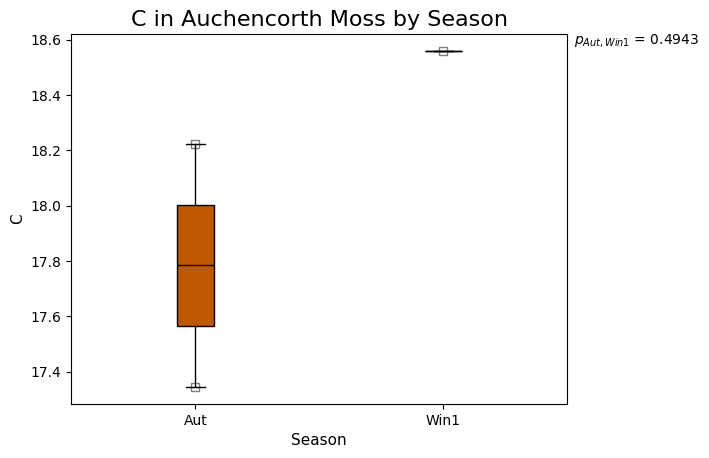

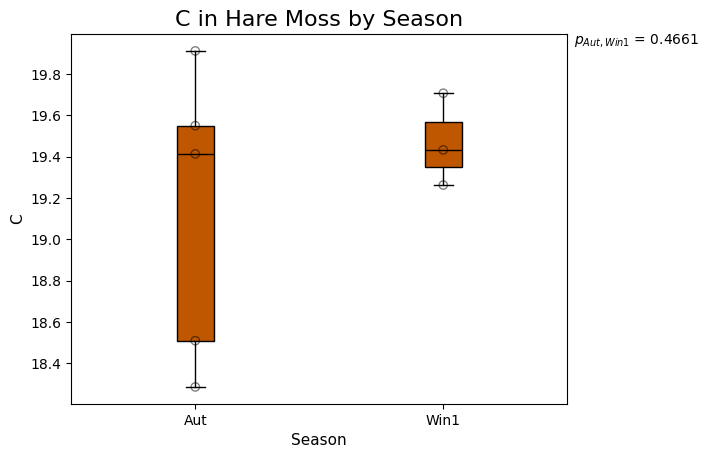

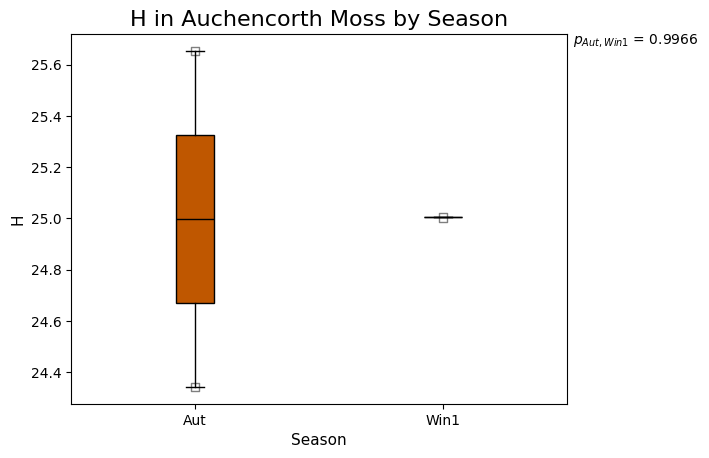

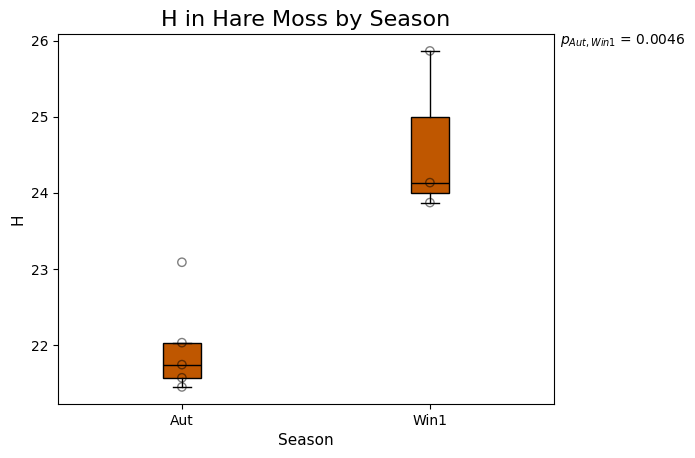

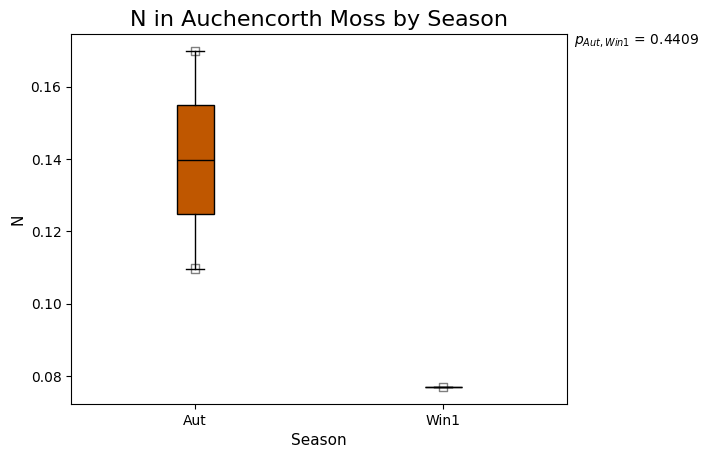

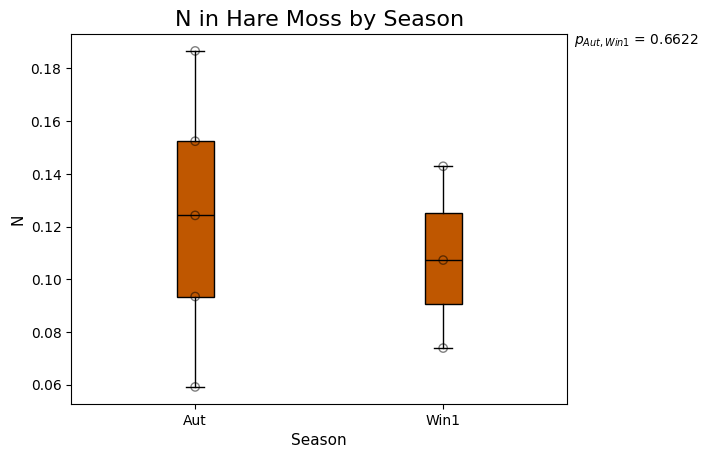

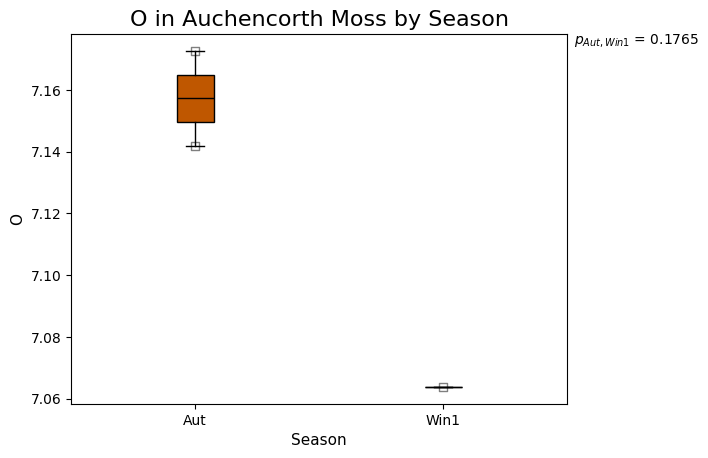

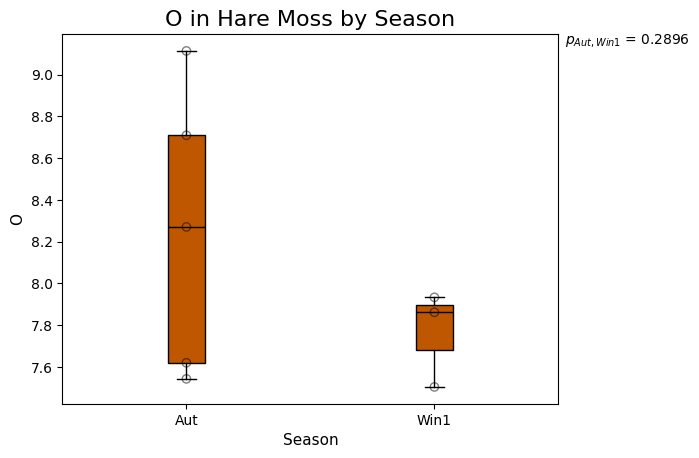

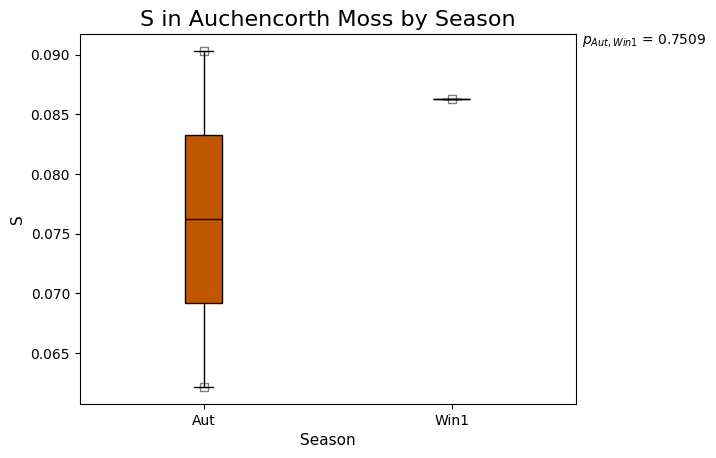

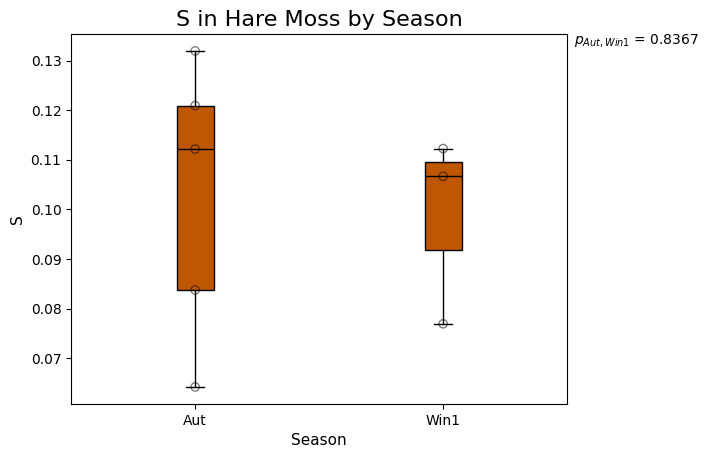

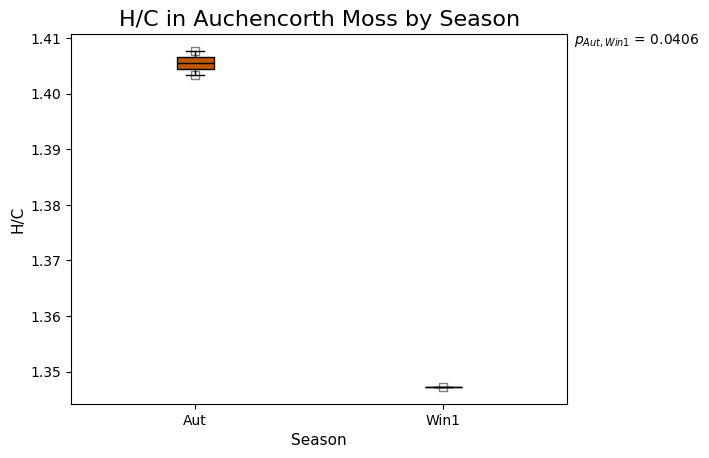

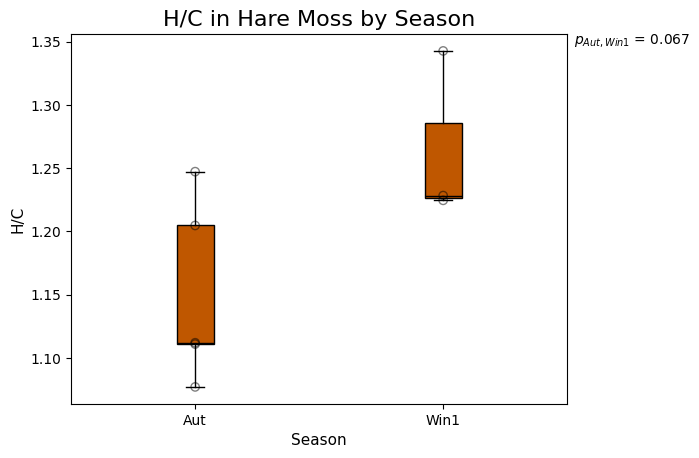

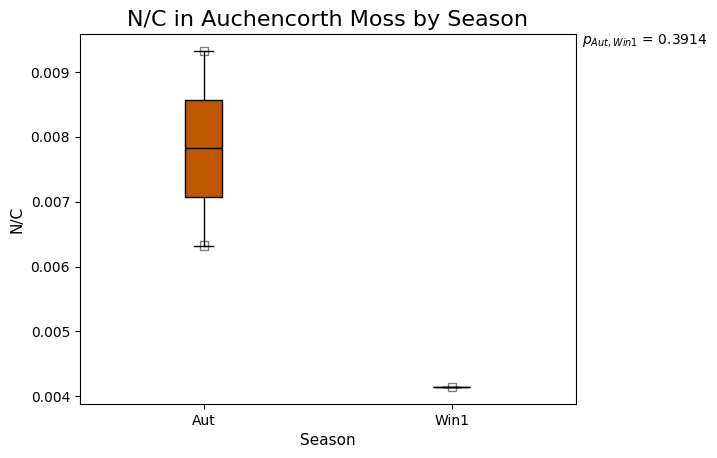

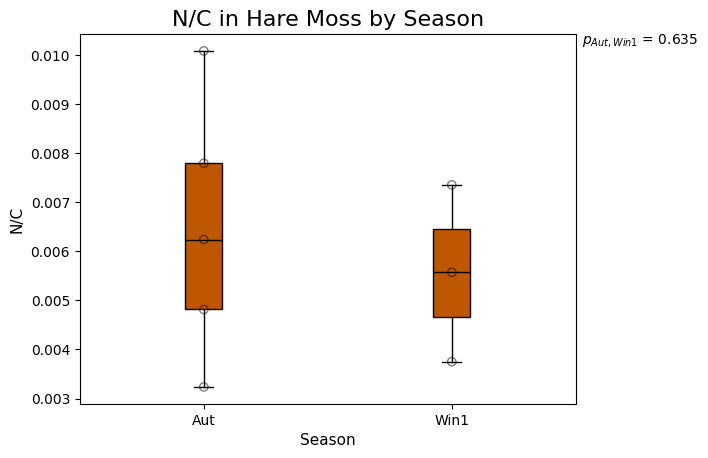

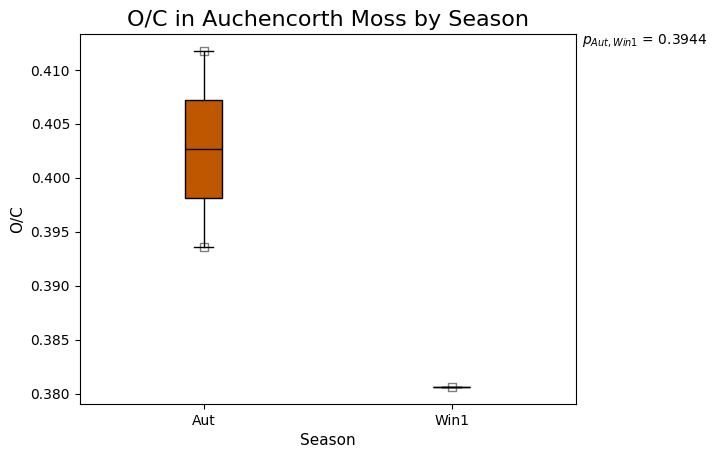

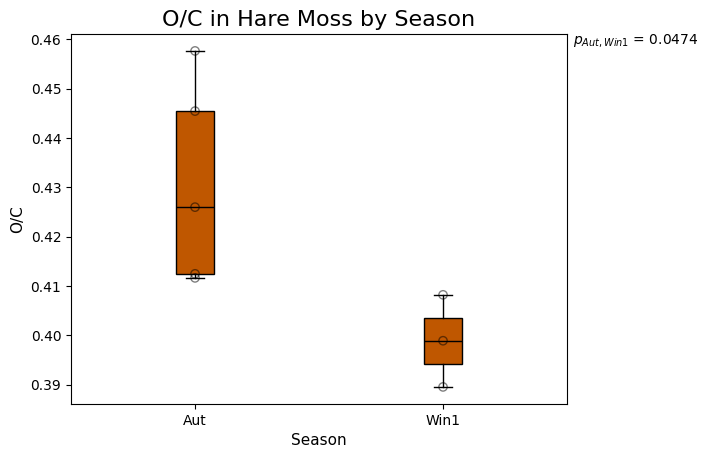

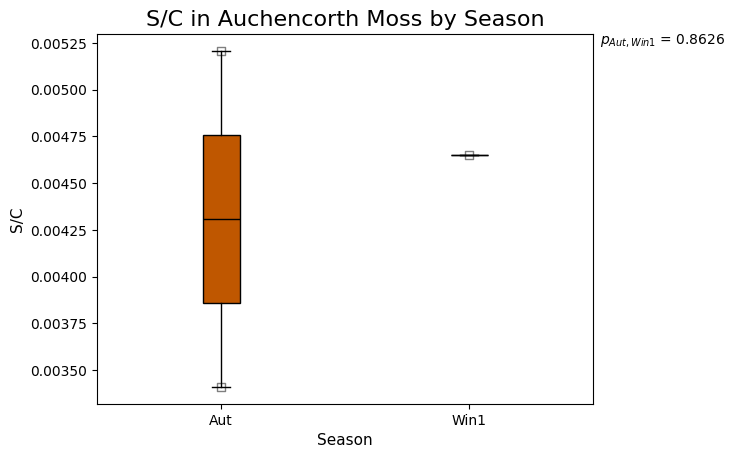

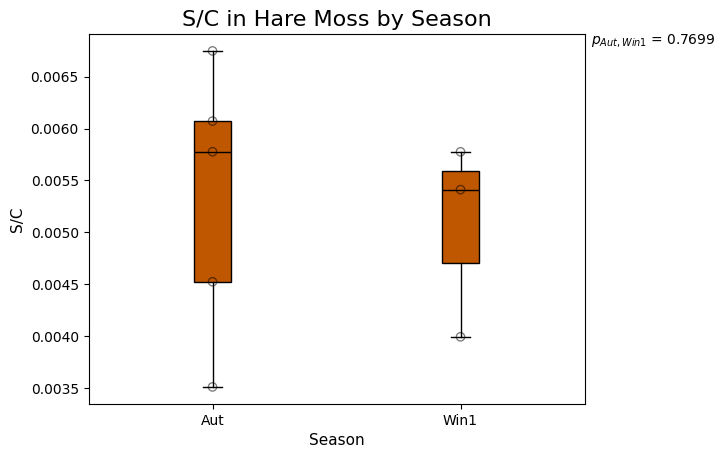

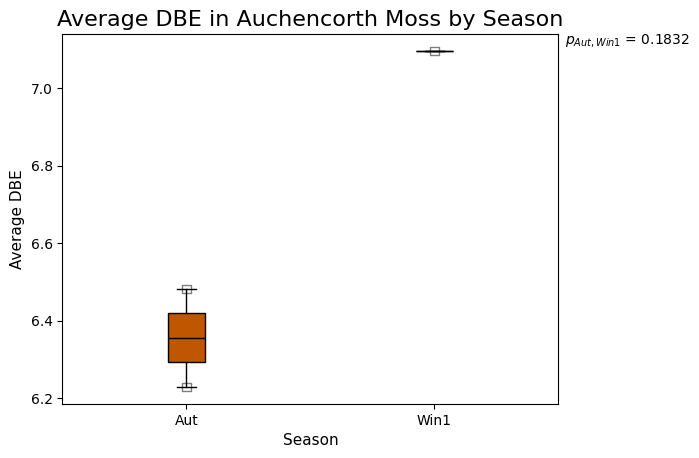

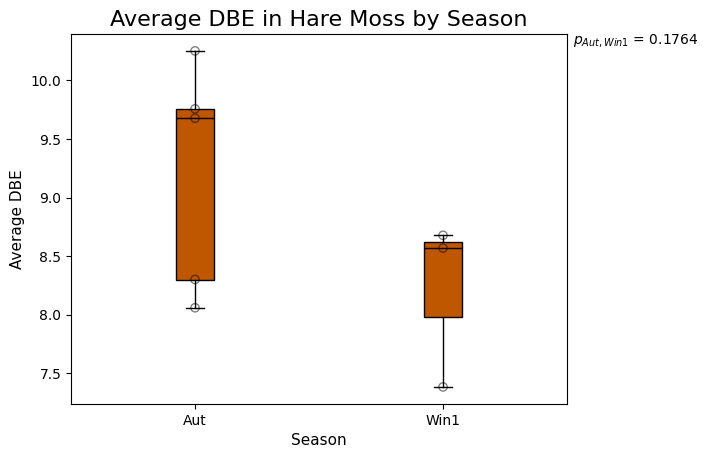

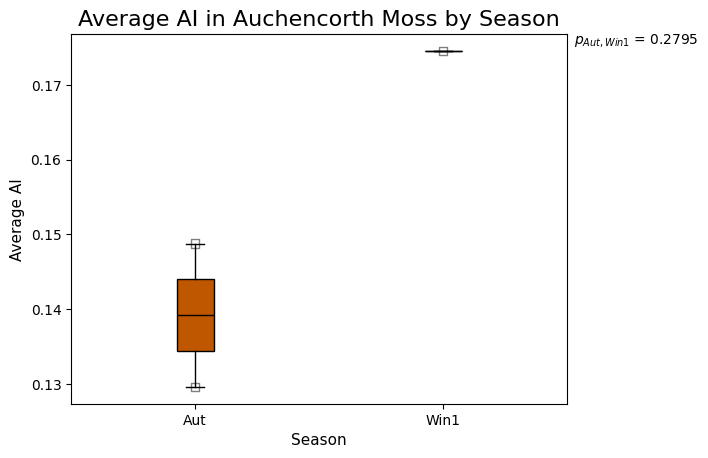

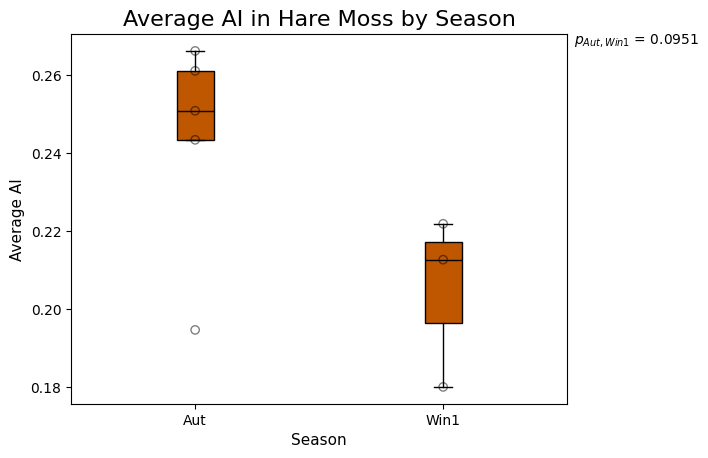

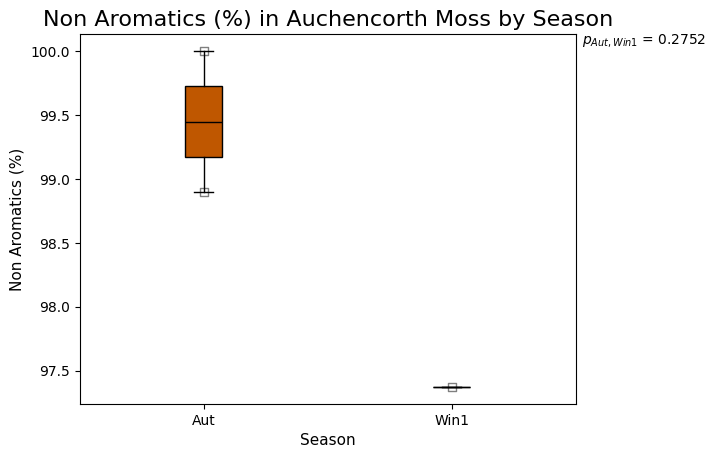

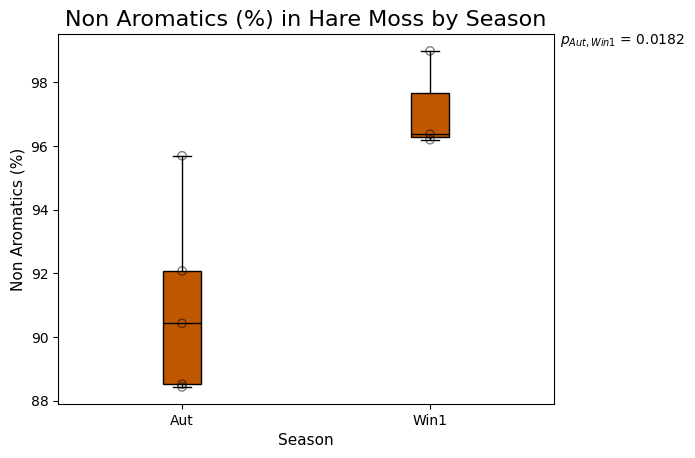

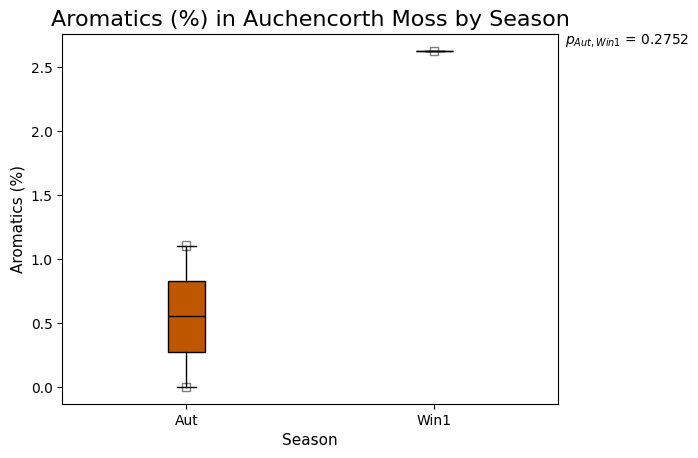

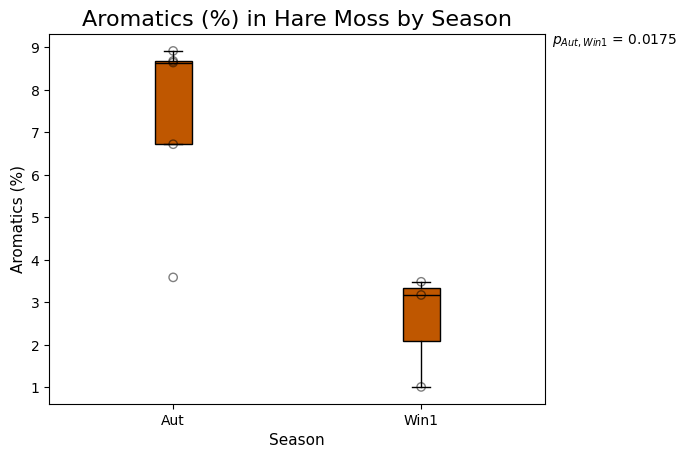

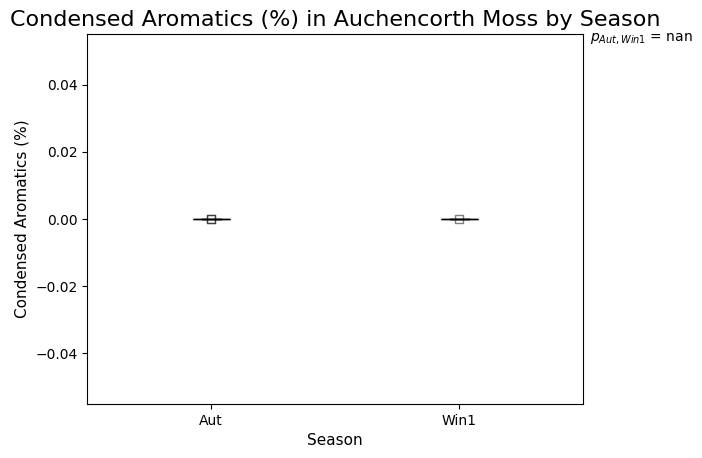

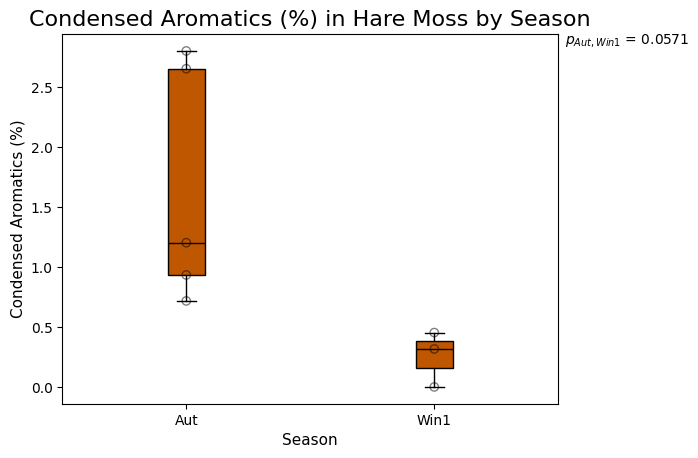

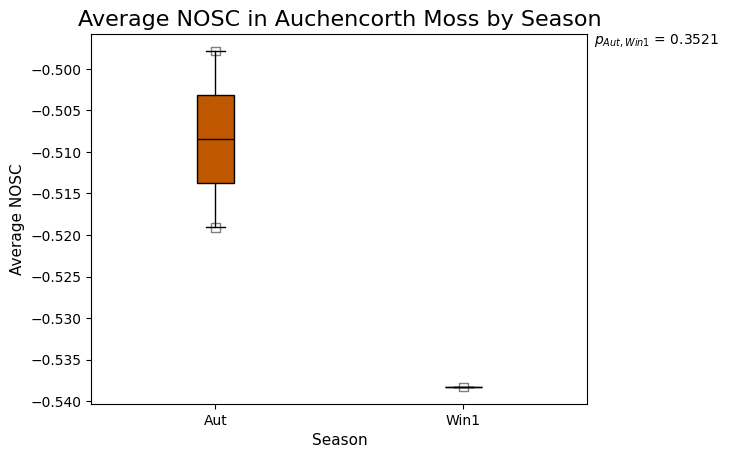

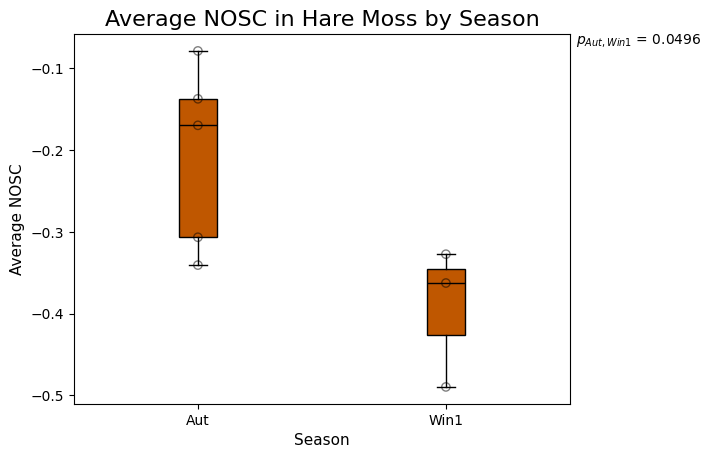

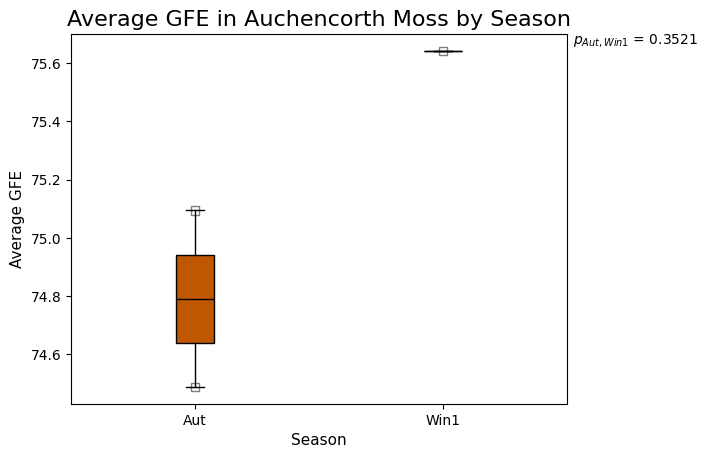

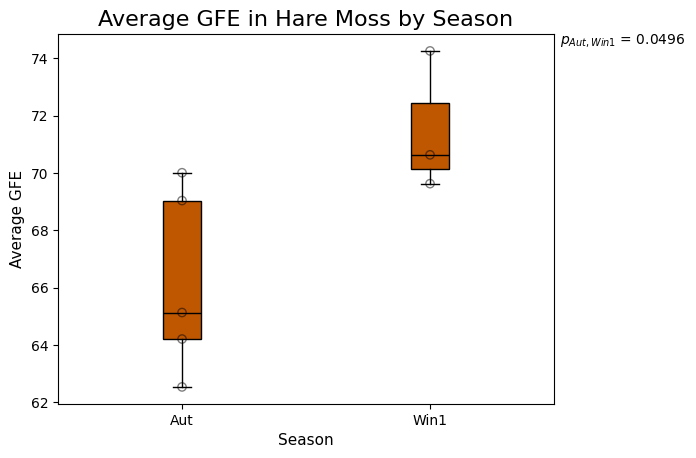

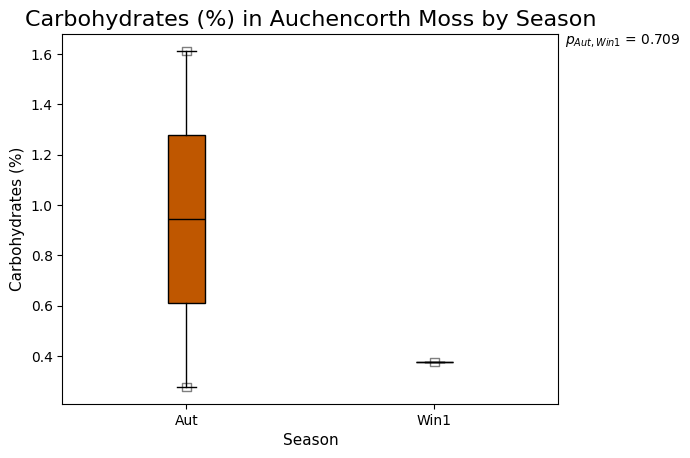

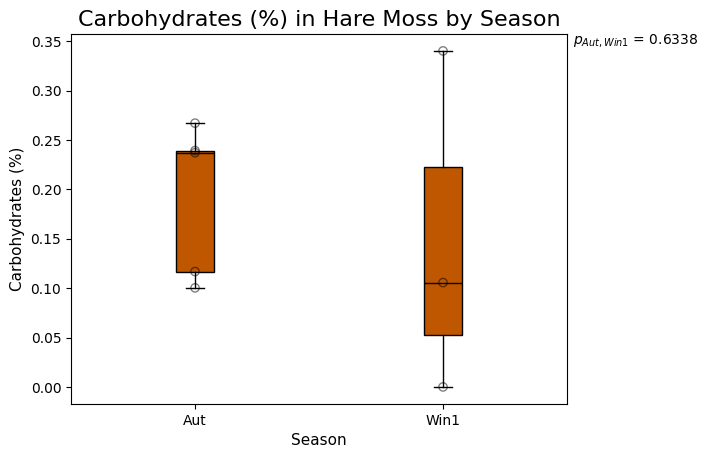

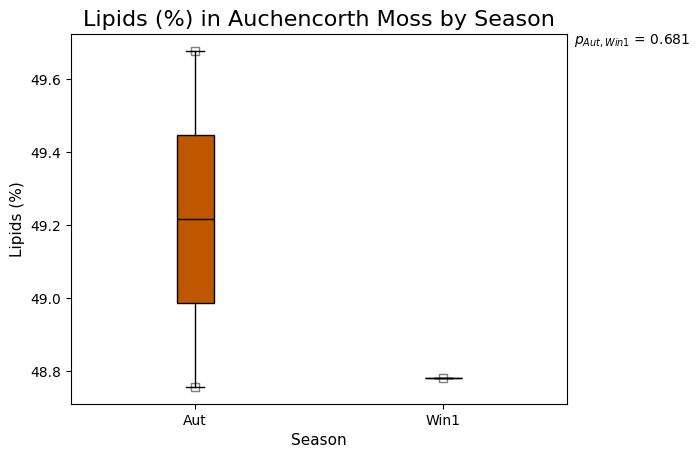

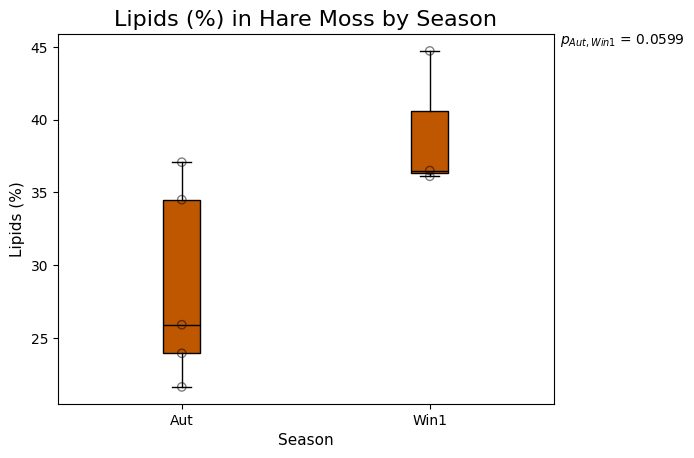

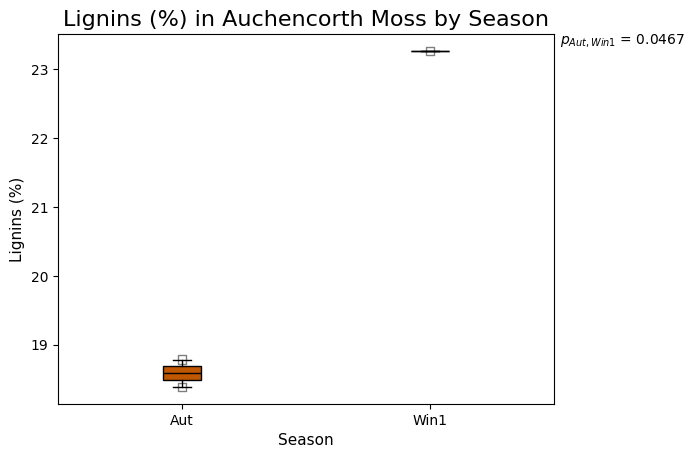

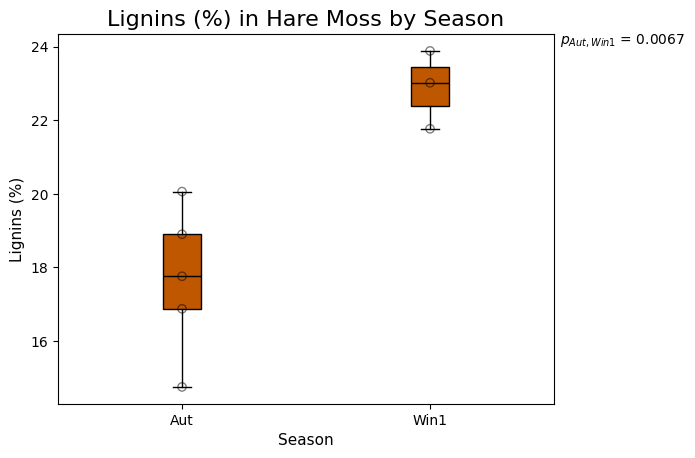

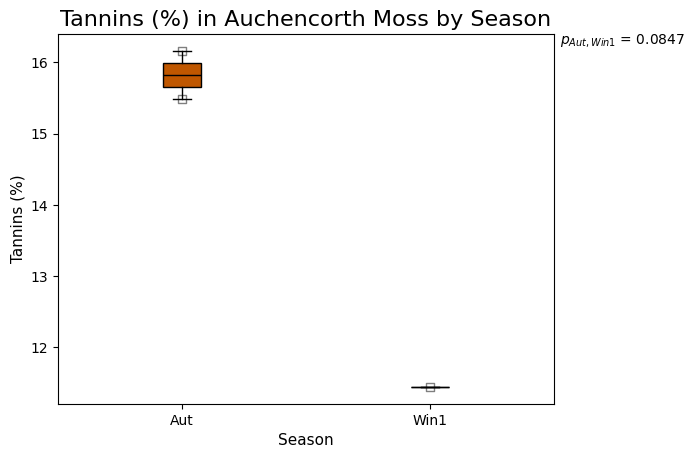

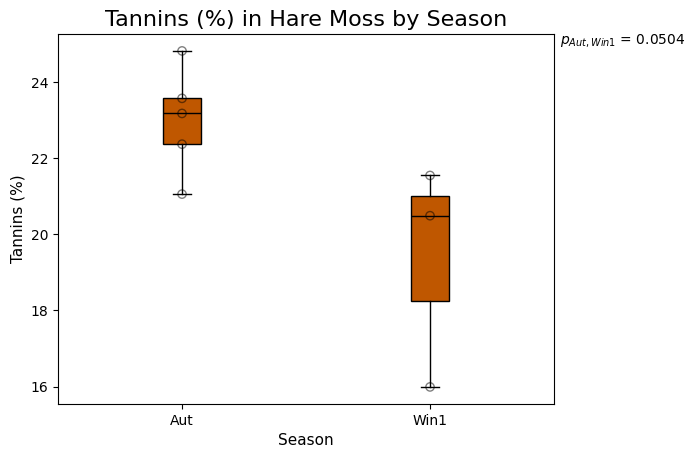

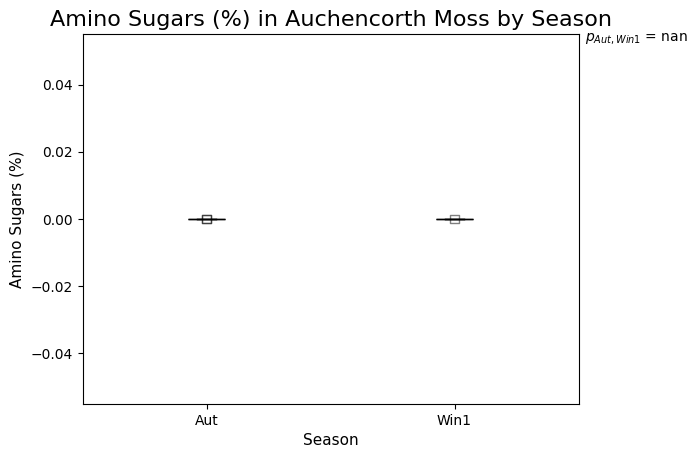

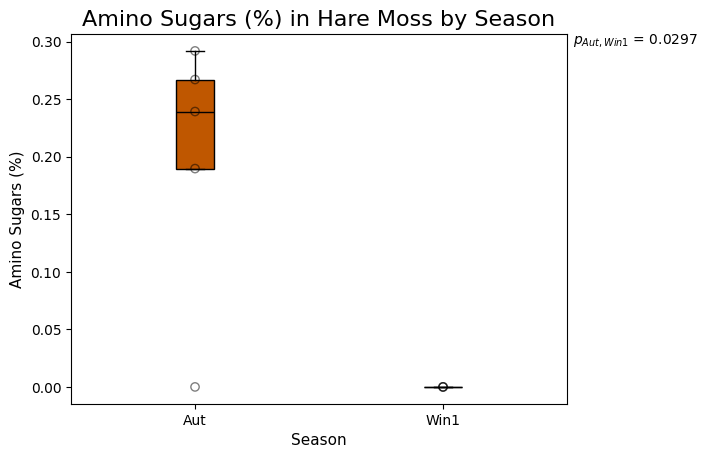

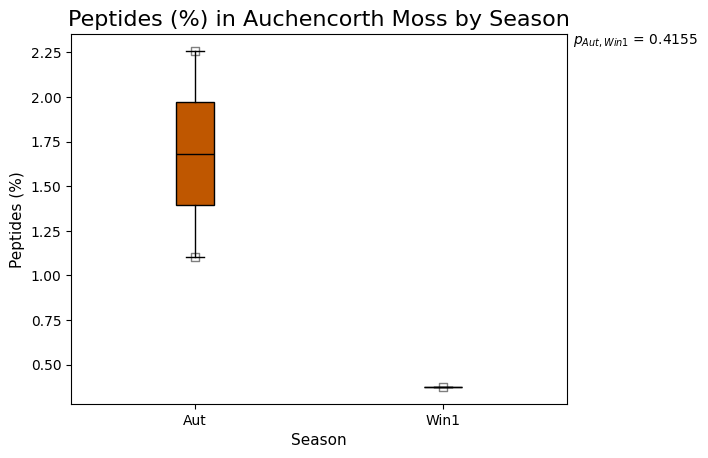

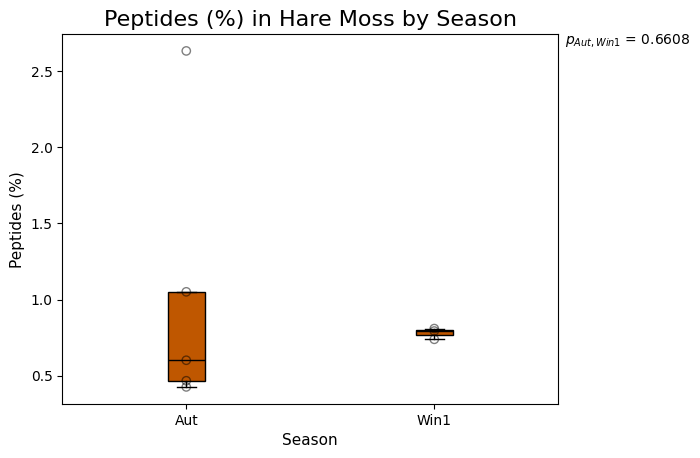

In [48]:
abbrs = ['nosc','ai','dbe','gfe']
for v in variables_metadata:
    for s in sites:
        fig_box, ax_box = plt.subplots()
        ylabel = v.replace('_',' ').replace('(','[').replace(')',']').replace('-1','$^{-1}$').replace('avg','Average')
        if ylabel != ylabel.upper(): ylabel=' '.join([y.capitalize() for y in ylabel.split(' ')])
        for abbr in abbrs:
            ylabel = ylabel.replace(abbr.capitalize(),abbr.upper())
        if '%' in ylabel: ylabel = ylabel.replace('%','(%)')

        boxplot_anova(df_metadata,s,'Site','season',v,ax=ax_box,ylabel=ylabel,xlabel='Season',title=f'{ylabel} in {s} by Season',
                      colours=[seasonal_colours[s] for s in seas_uniq],marker=m_shape[sitesshort[s]])

        fig_box.savefig(f'anova_plots/by_season/{sitesshort[s]}_{ylabel.replace(' ','_').replace('/','').lower()}.svg', dpi = 600, facecolor = '#fff', bbox_inches='tight')
        
        # for i in range(len(df_metadata)):
        #     ax_box.scatter([i+1]*len(df_metadata[i]),df_metadata[i],zorder=-2,alpha=.5)

In [49]:
for k in sitesshort:
    df_metadata[df_metadata==k] = sitesshort[k]

C:\Users\s2017658\AppData\Local\Temp\ipykernel_10112\3948917579.py:38: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  p_dict[f'{level_unique[comb[0]]},{level_unique[comb[1]]}'] = stats.f_oneway(*[x[comb[0]],x[comb[1]]],nan_policy='omit')[1]
C:\Users\s2017658\AppData\Local\Temp\ipykernel_10112\3948917579.py:38: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  p_dict[f'{level_unique[comb[0]]},{level_unique[comb[1]]}'] = stats.f_oneway(*[x[comb[0]],x[comb[1]]],nan_policy='omit')[1]
C:\Users\s2017658\AppData\Local\Temp\ipykernel_10112\3948917579.py:38: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  p_dict[f'{level_unique[comb[0]]},{level_unique[comb[1]]}'] = stats.f_oneway(*[x[comb[0]],x[comb[1]]],na

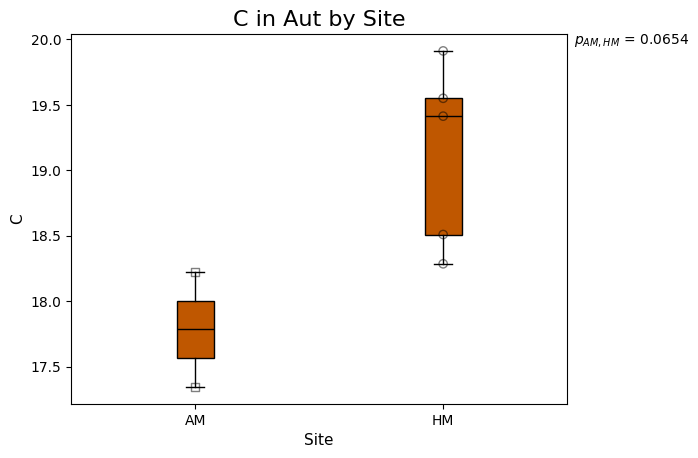

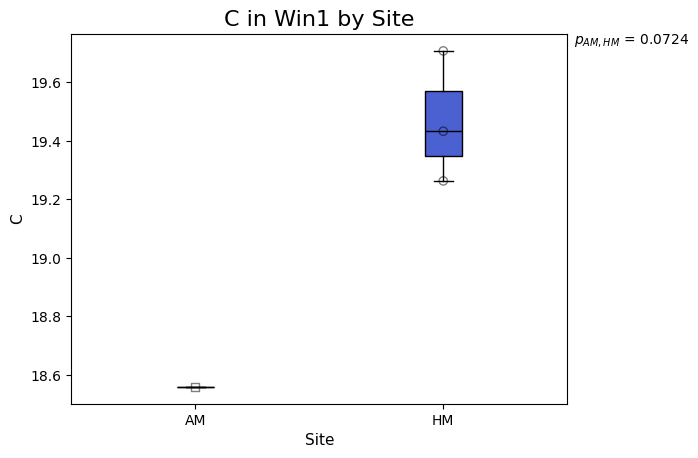

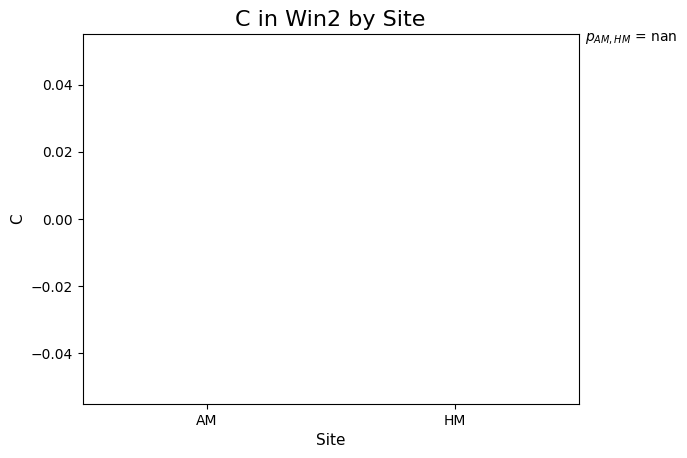

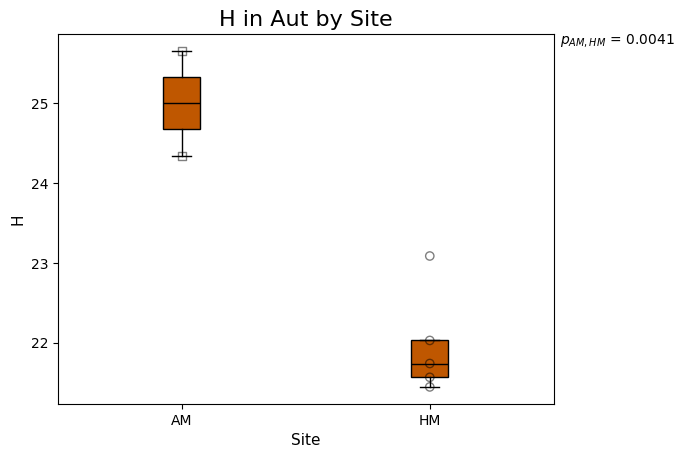

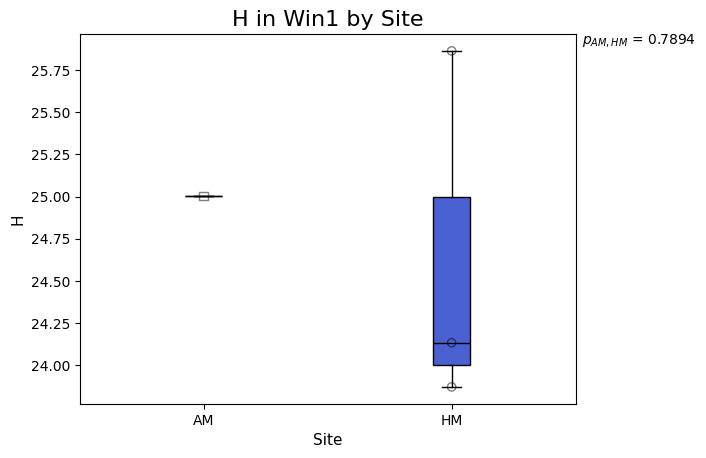

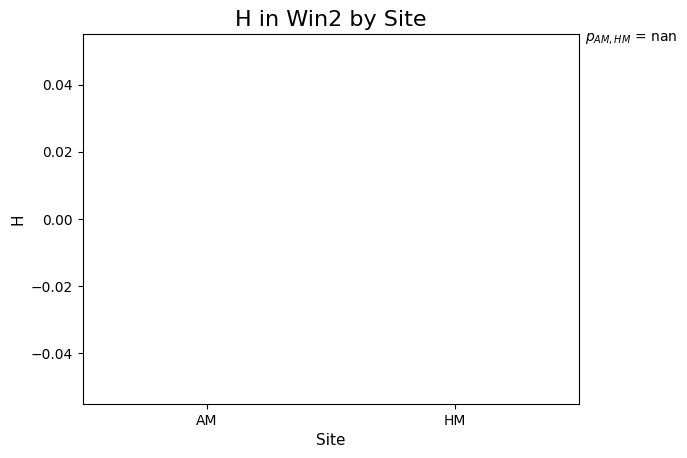

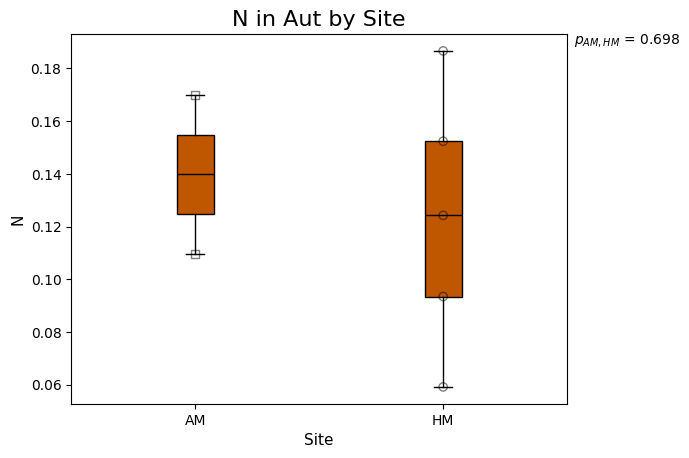

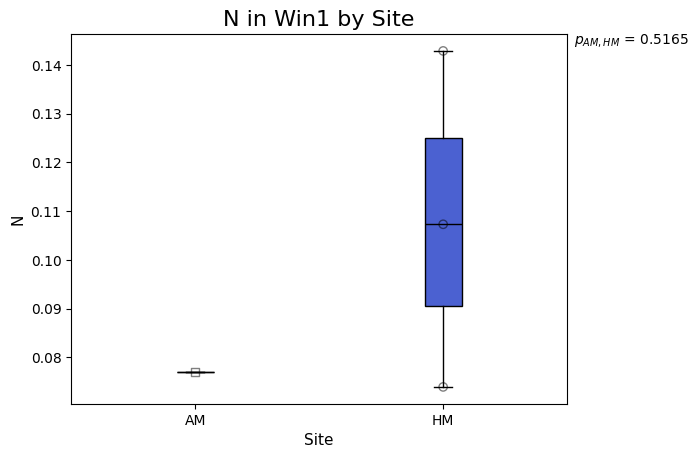

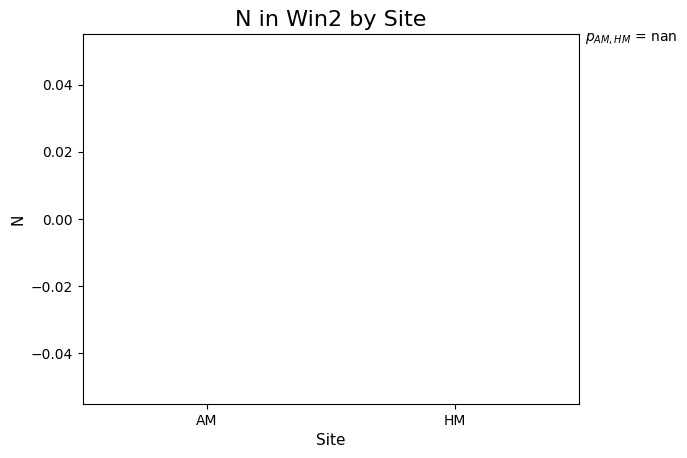

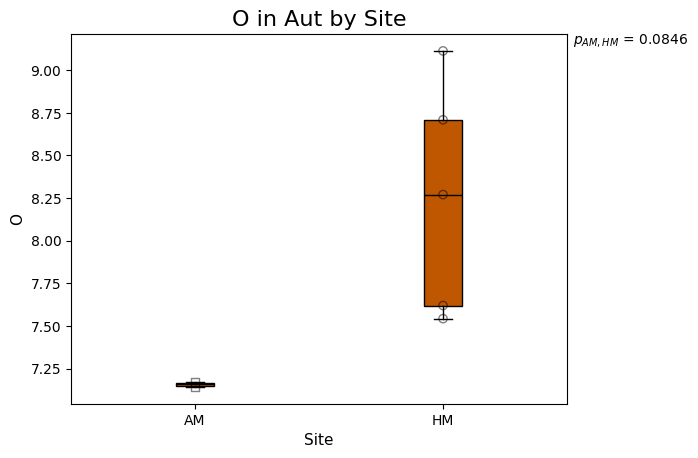

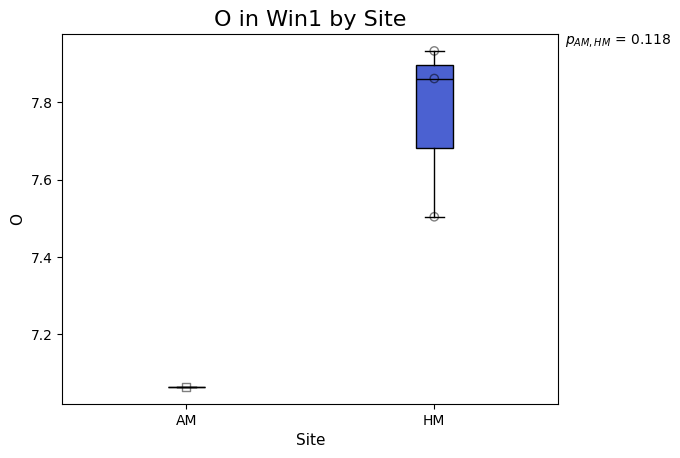

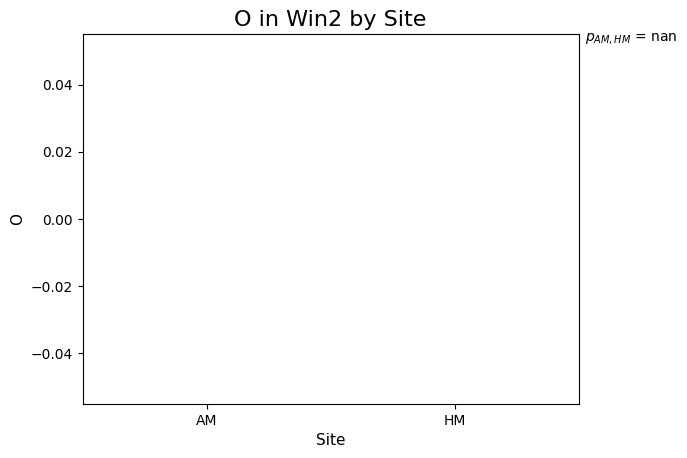

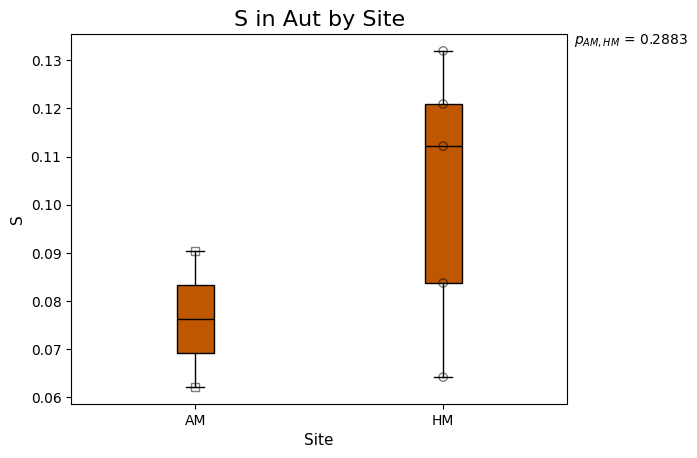

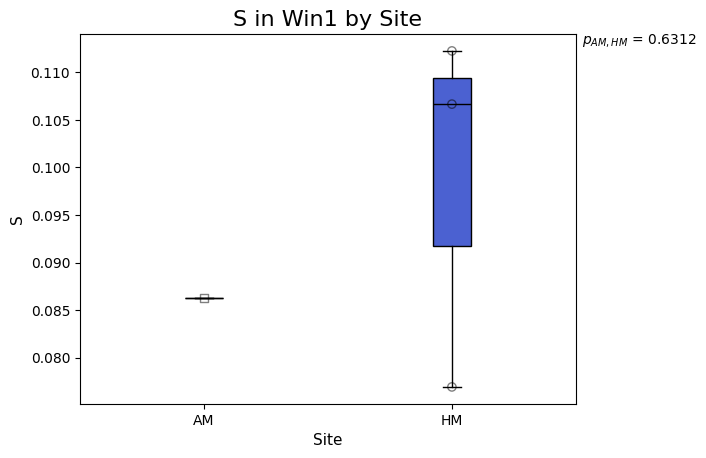

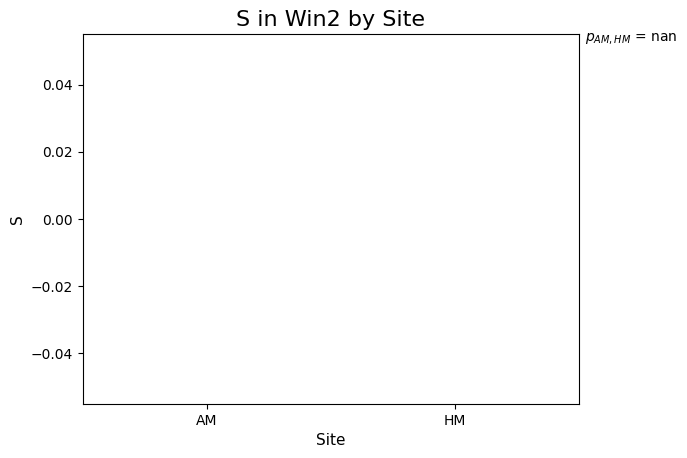

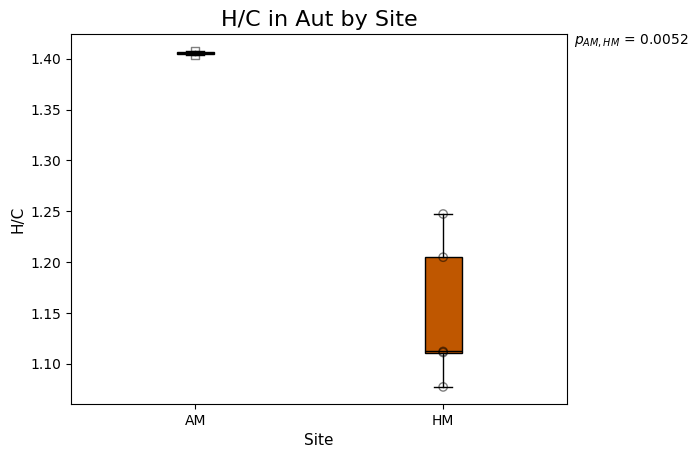

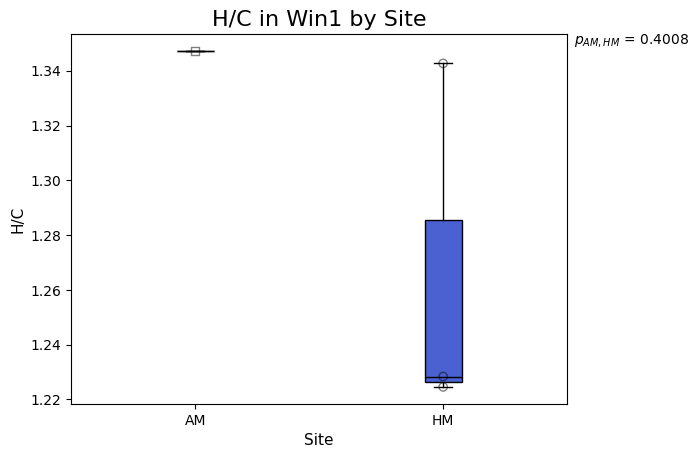

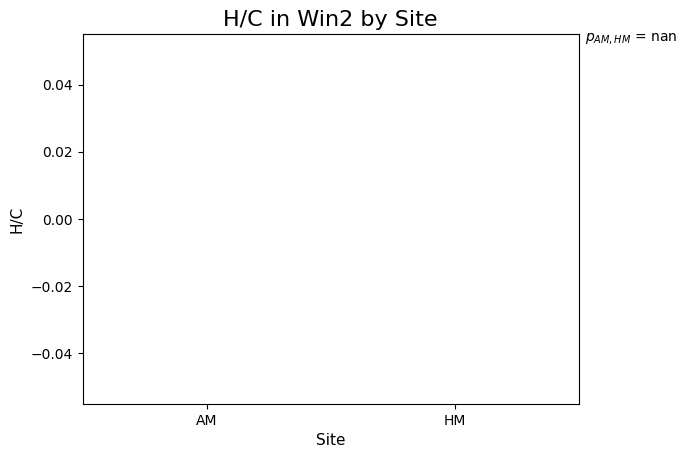

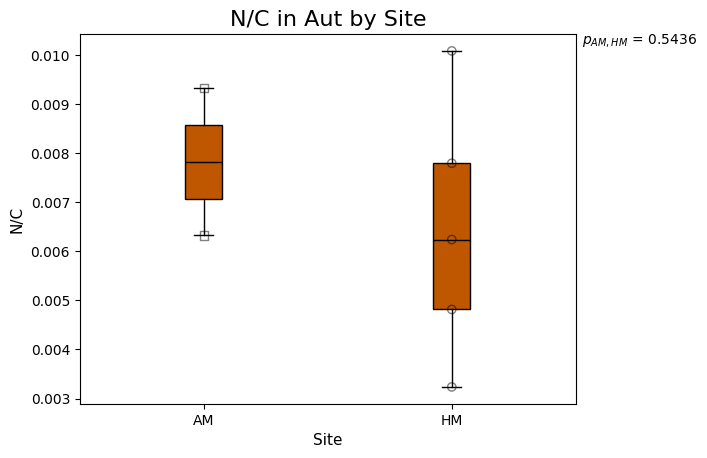

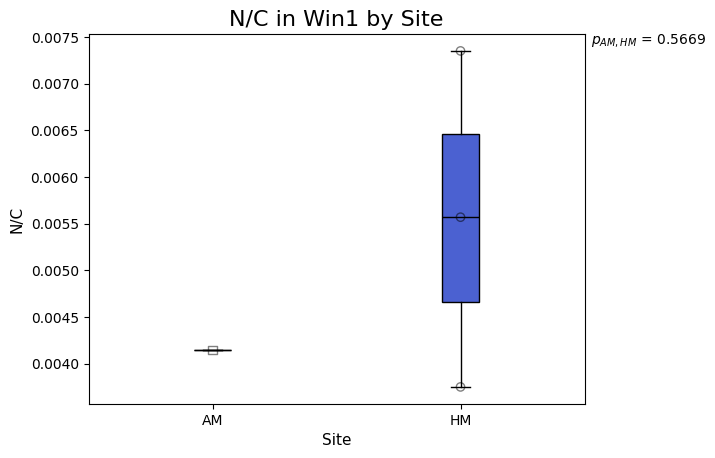

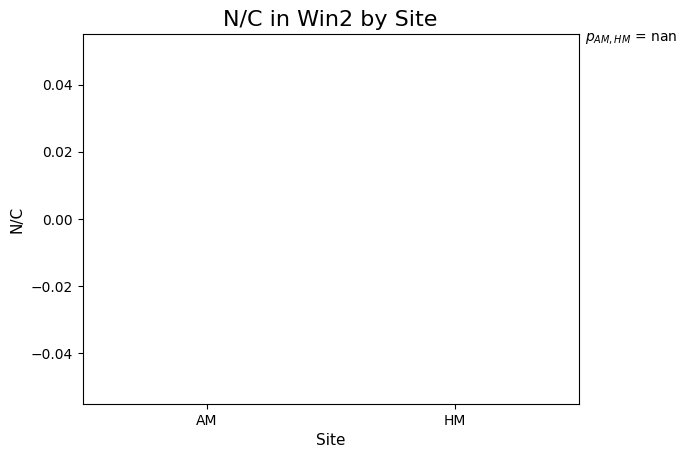

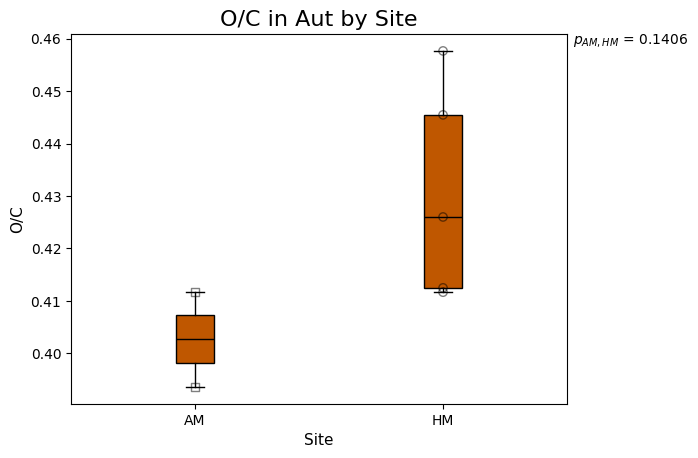

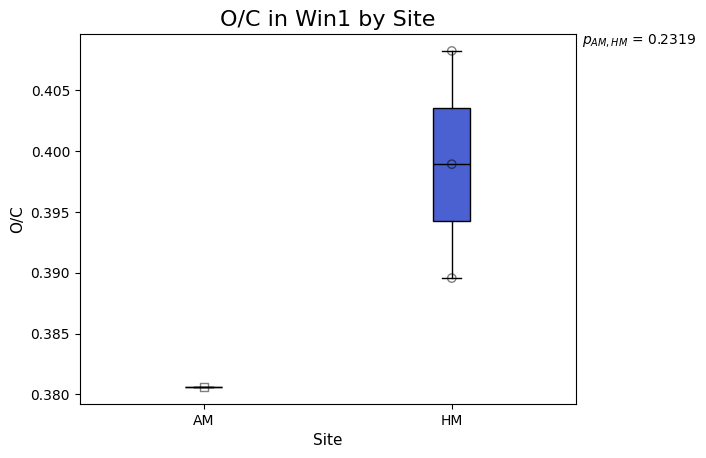

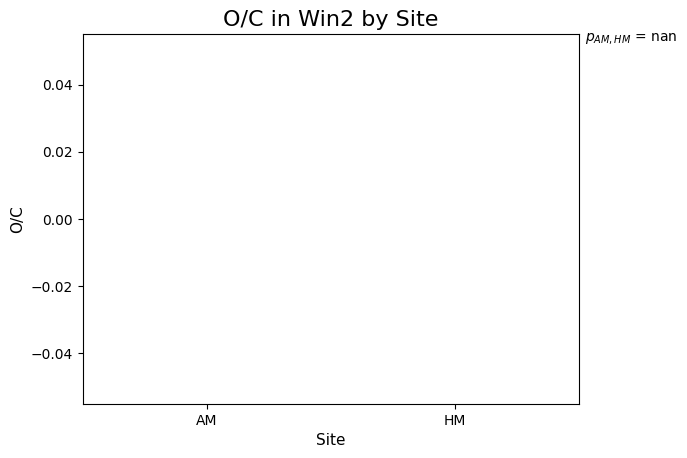

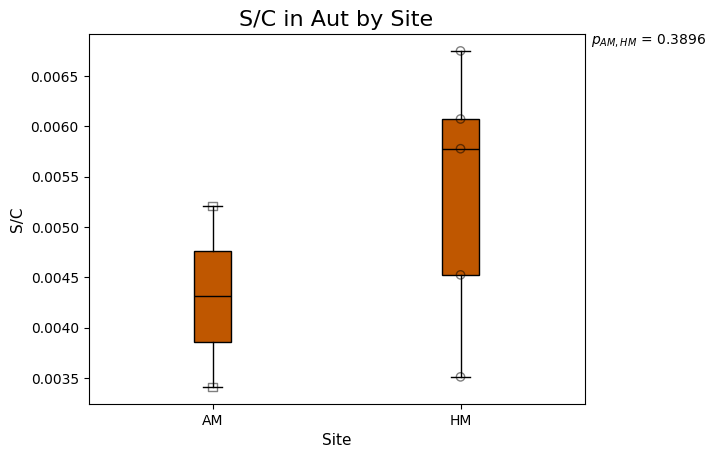

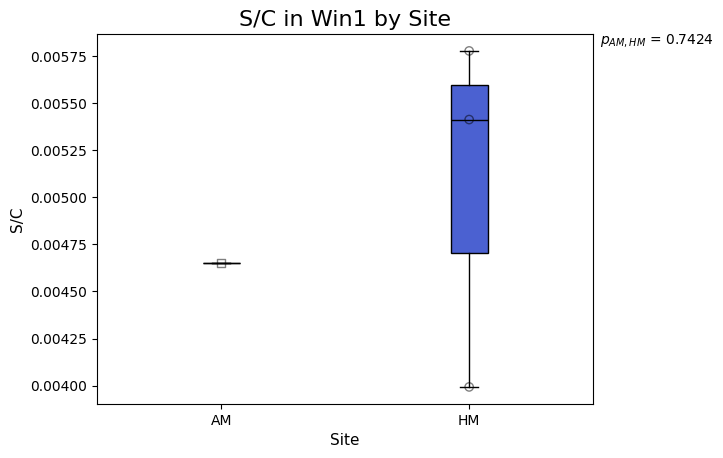

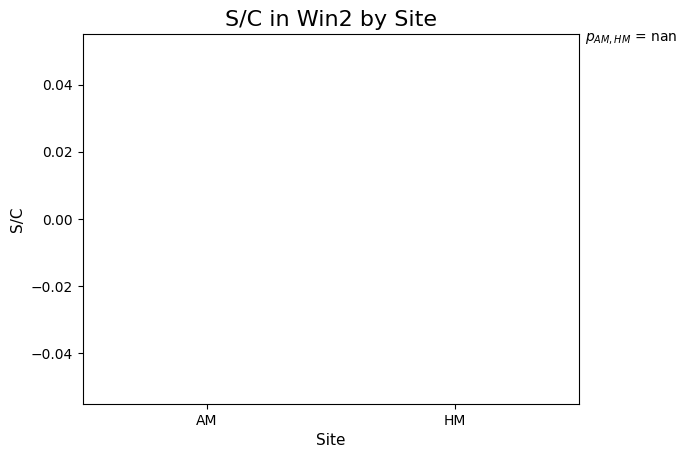

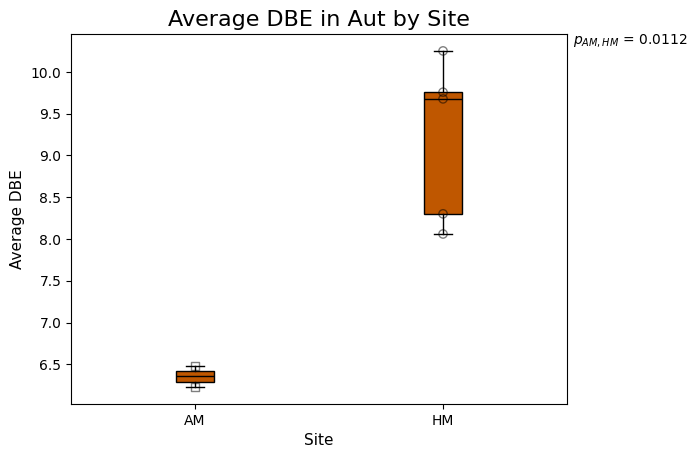

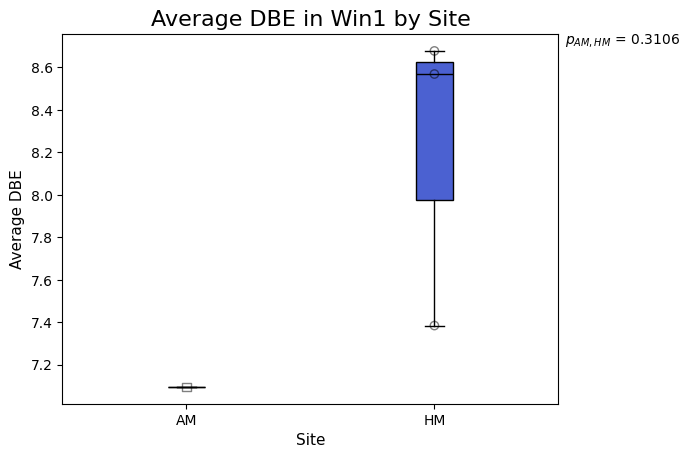

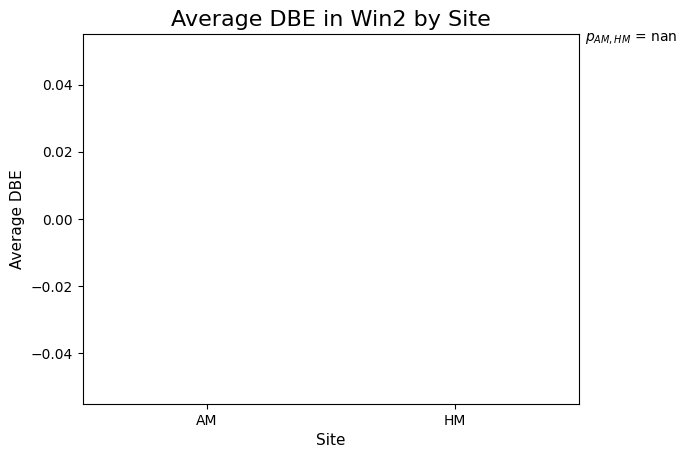

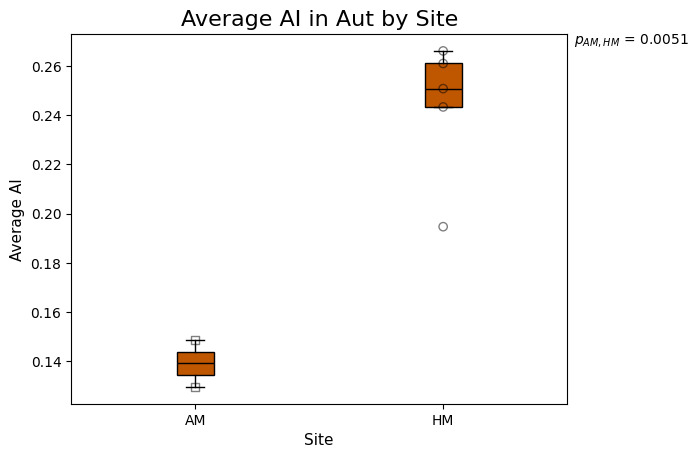

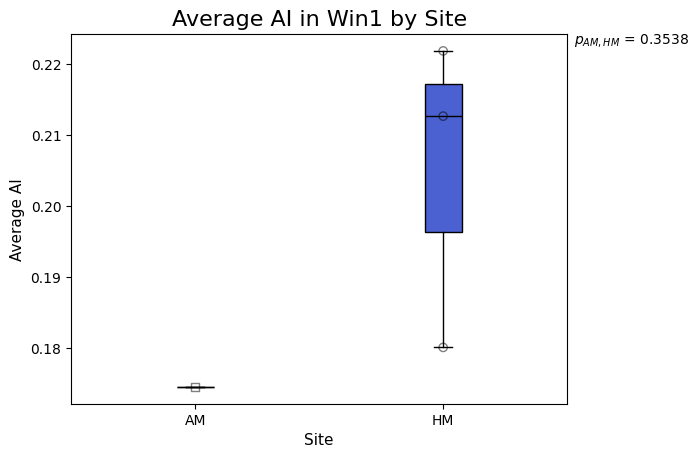

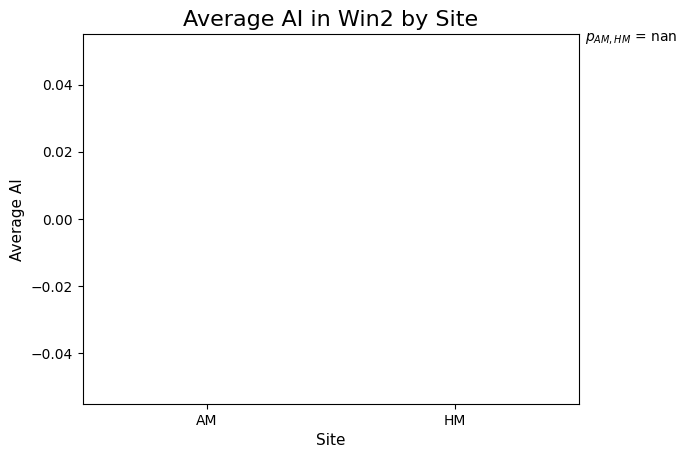

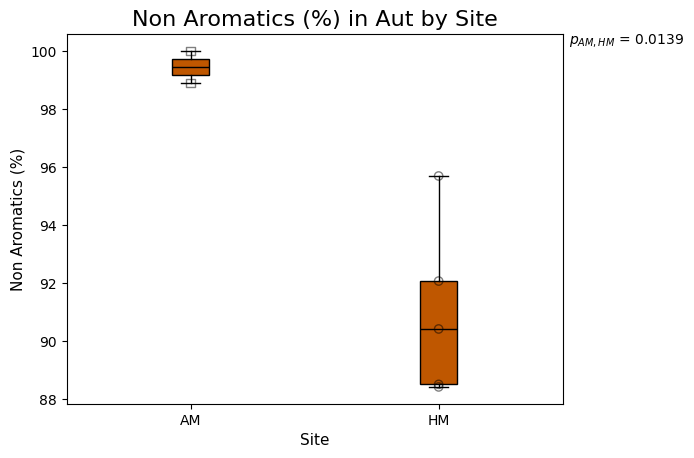

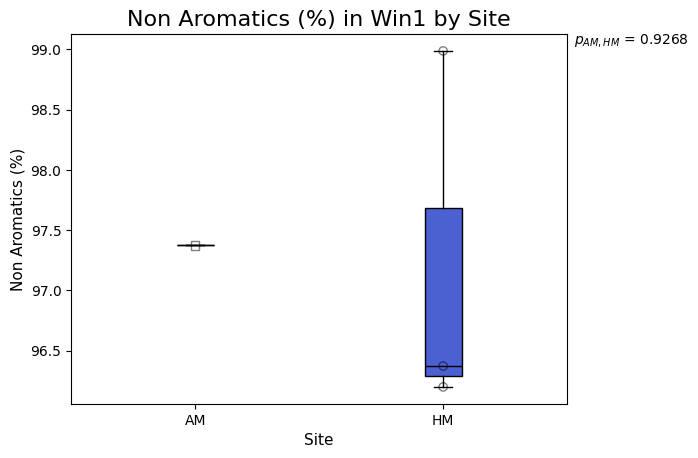

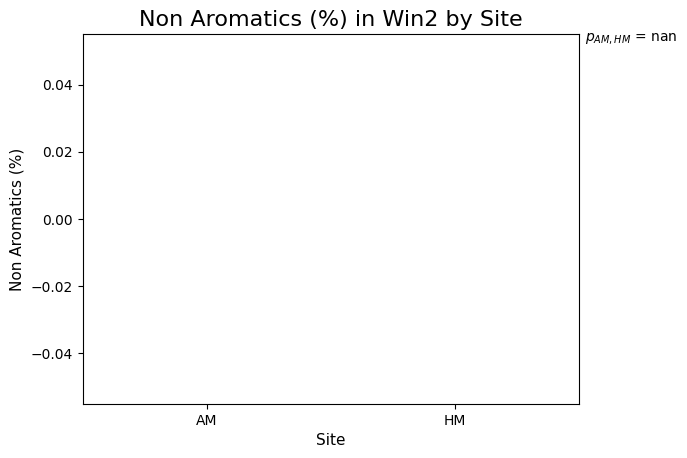

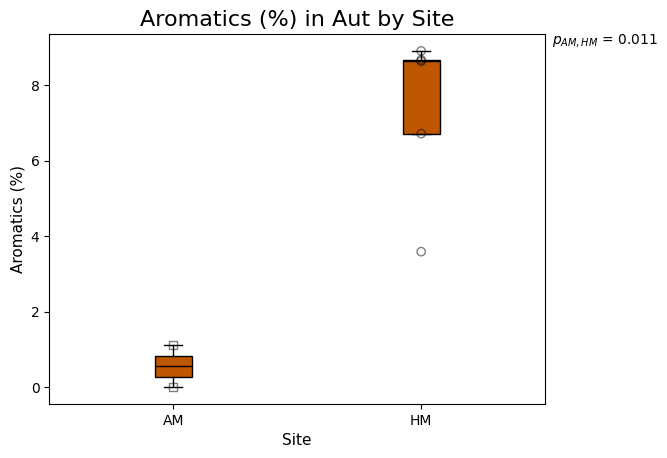

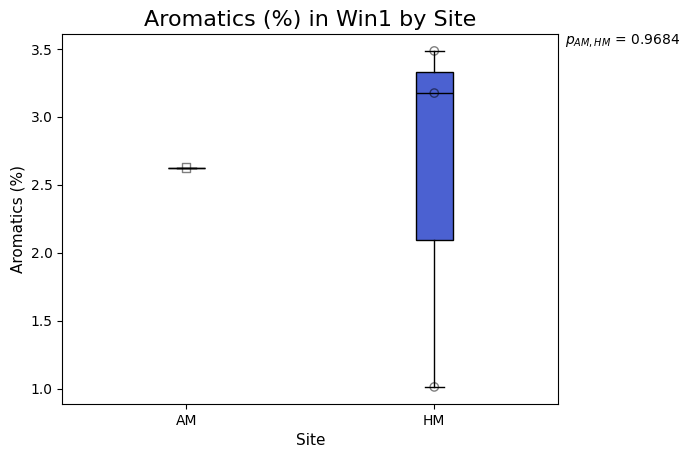

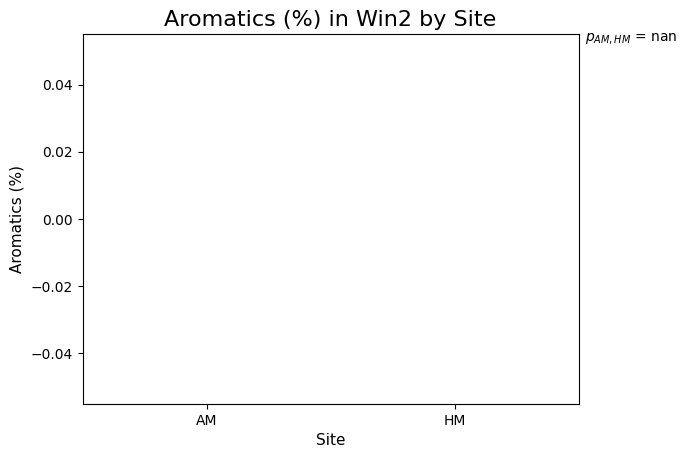

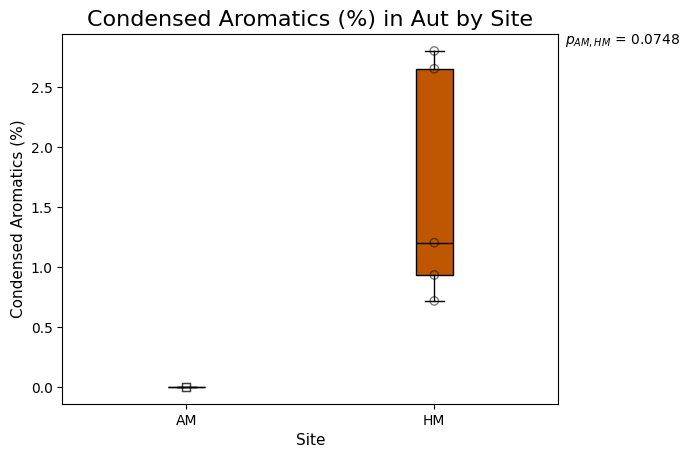

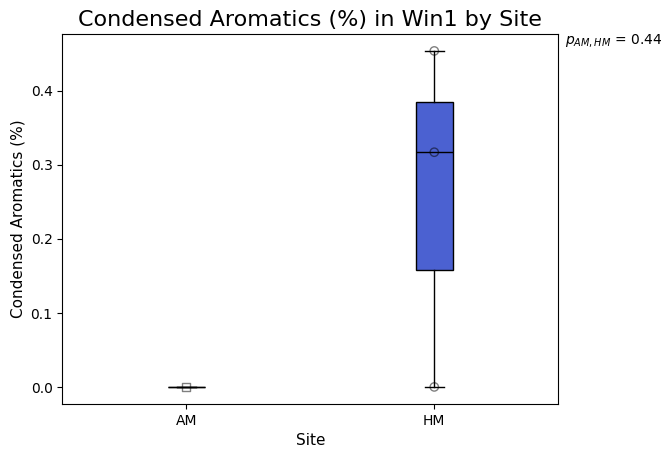

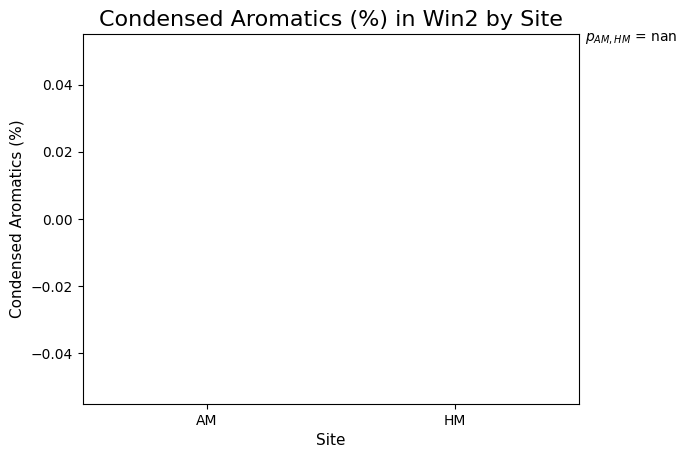

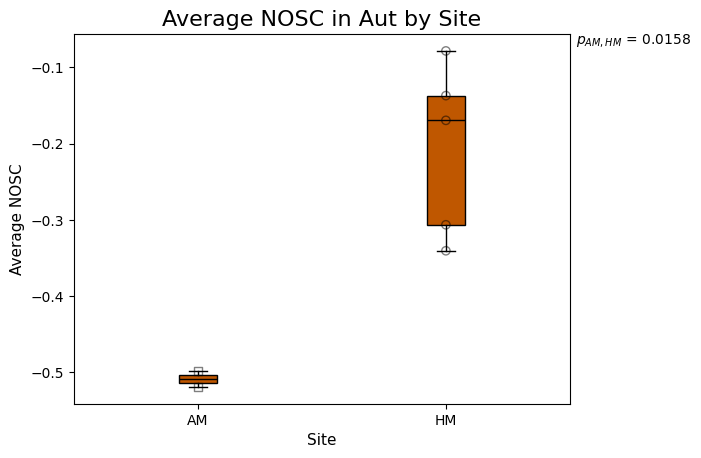

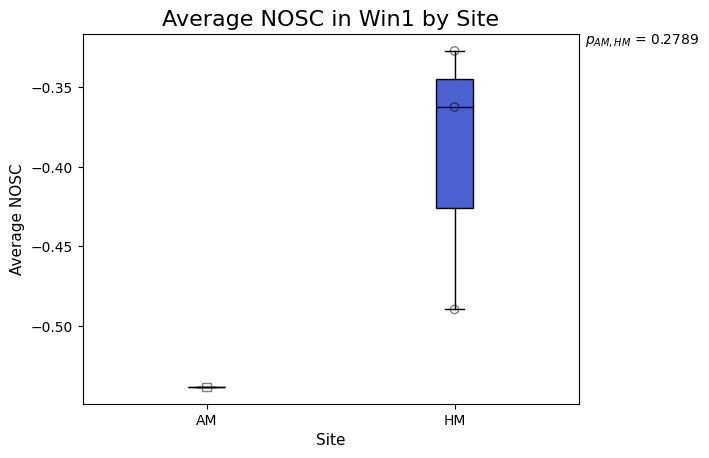

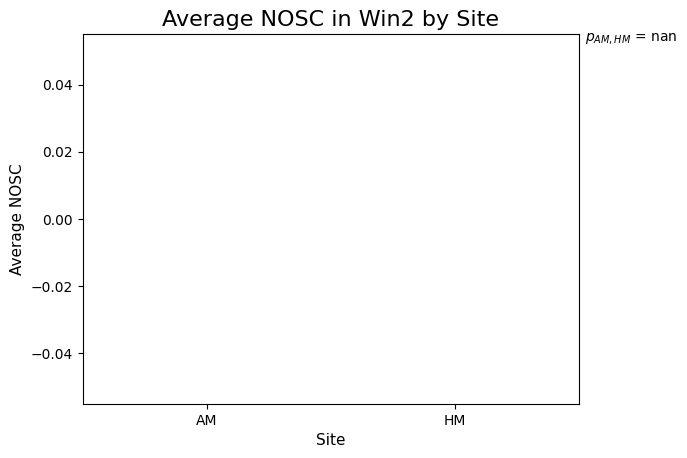

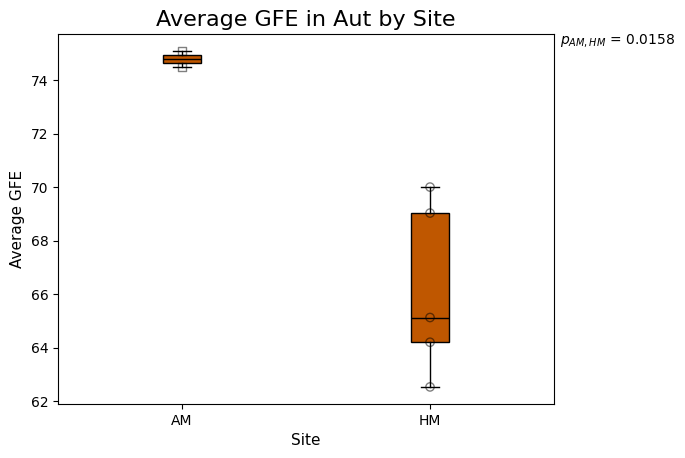

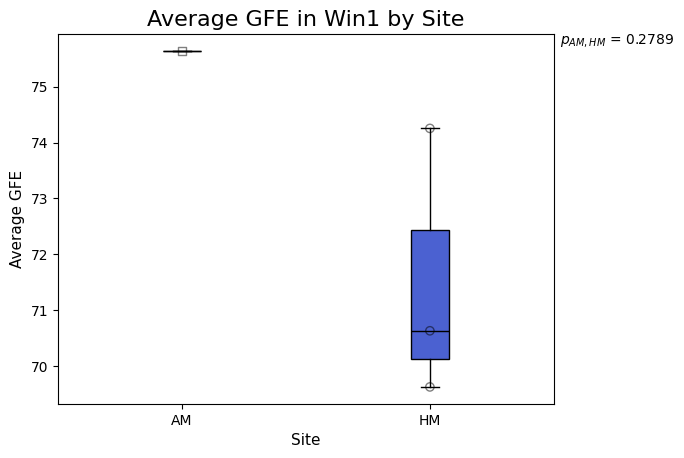

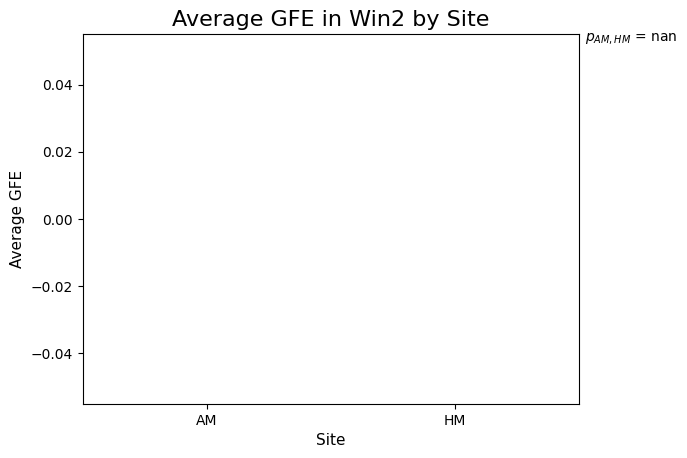

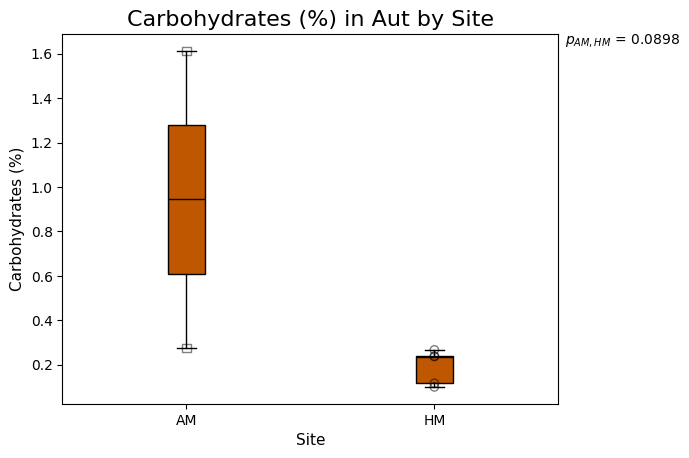

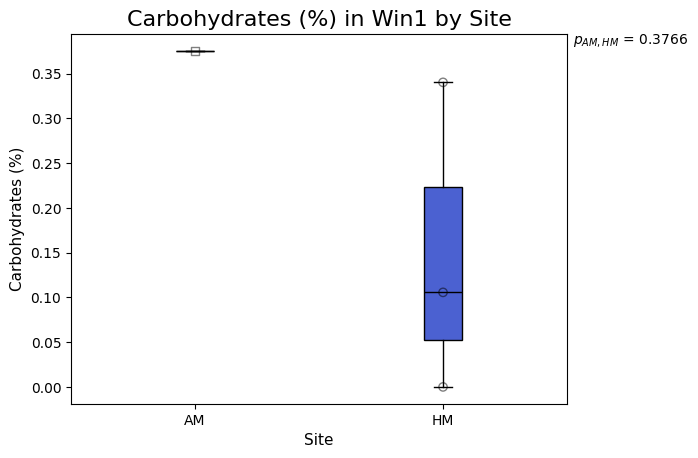

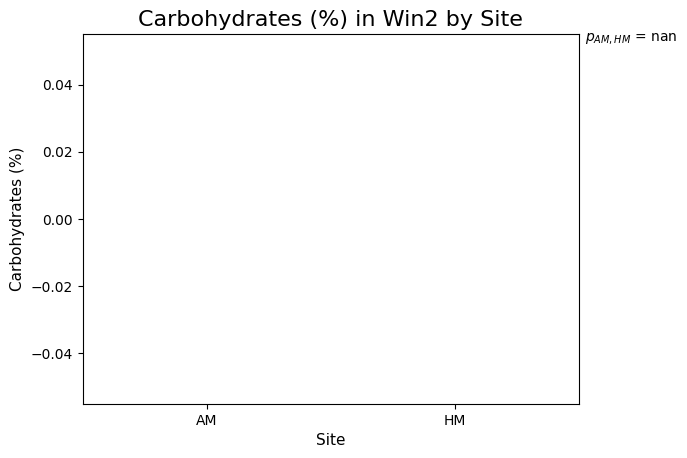

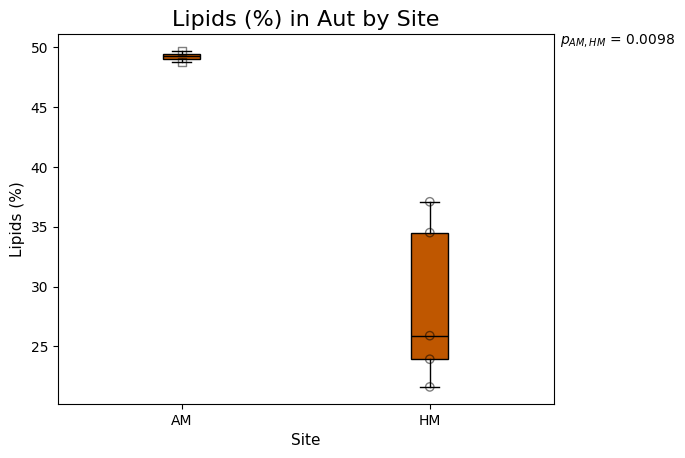

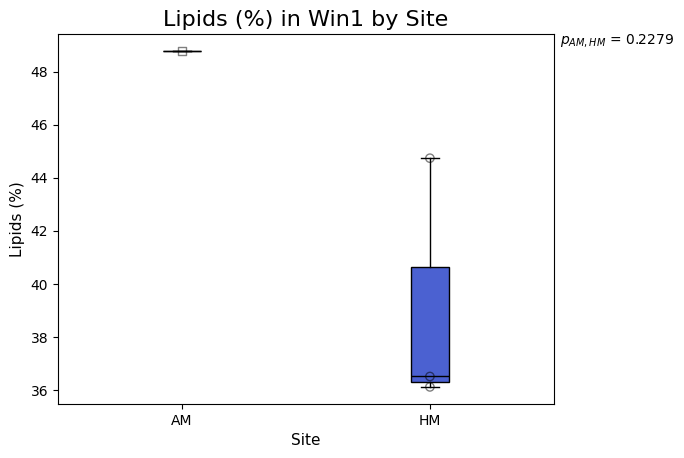

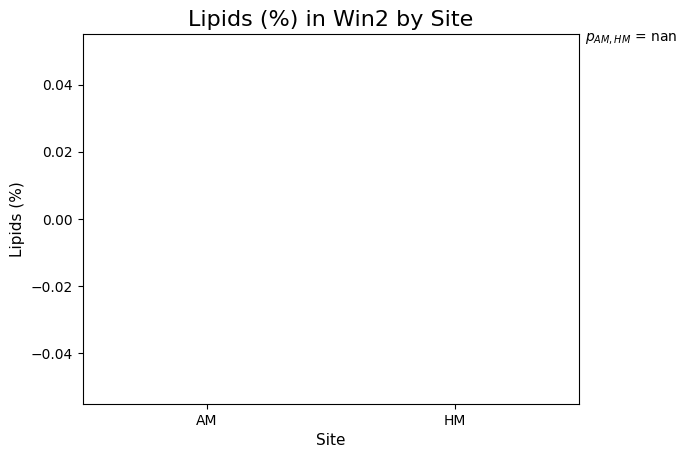

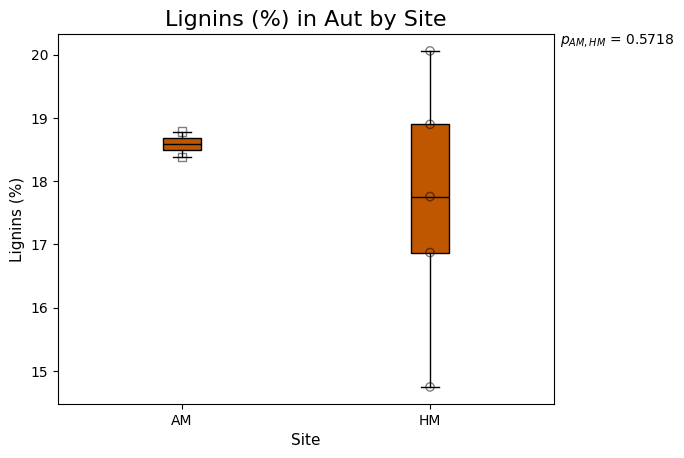

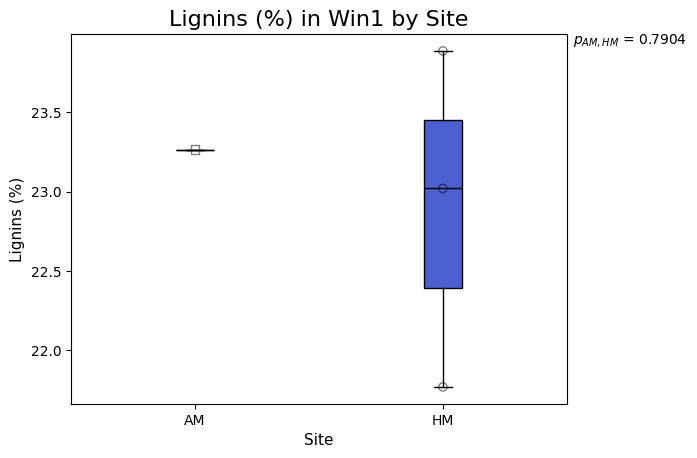

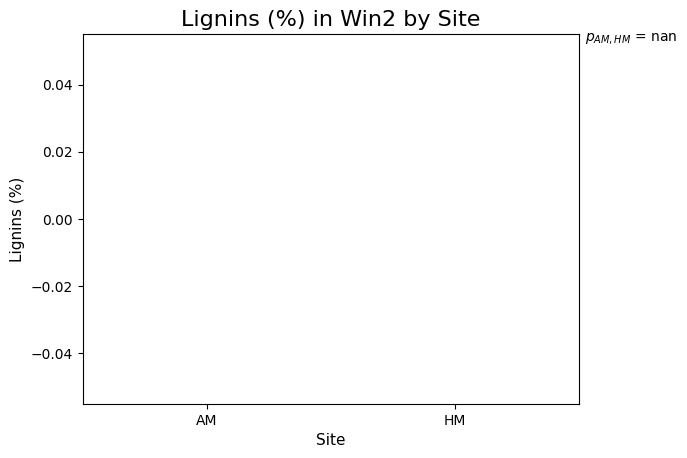

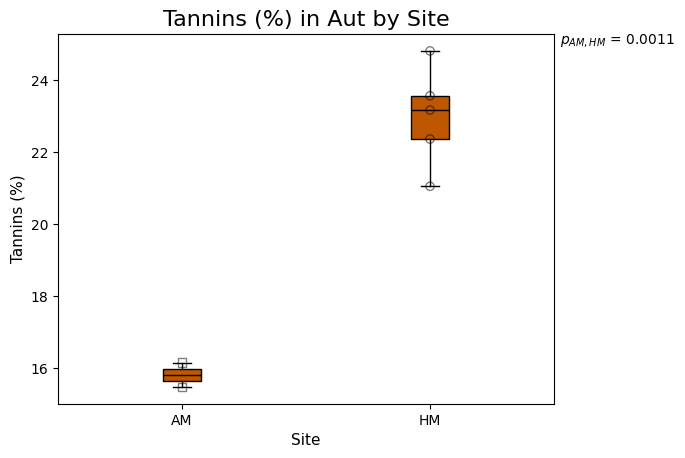

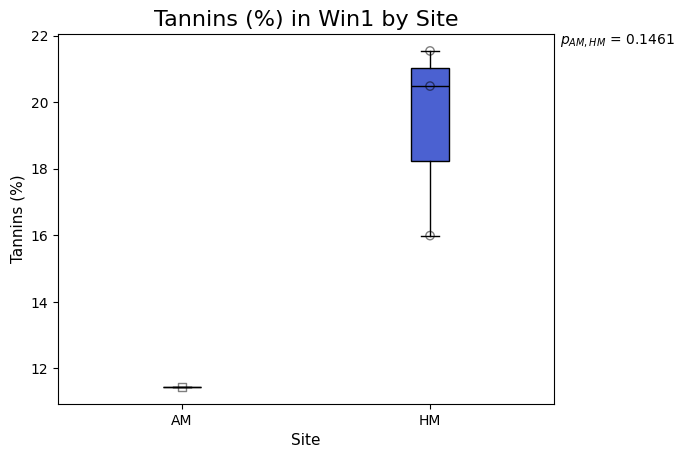

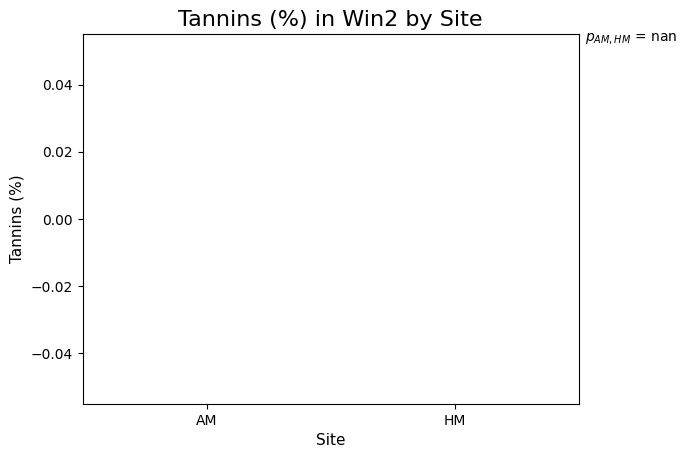

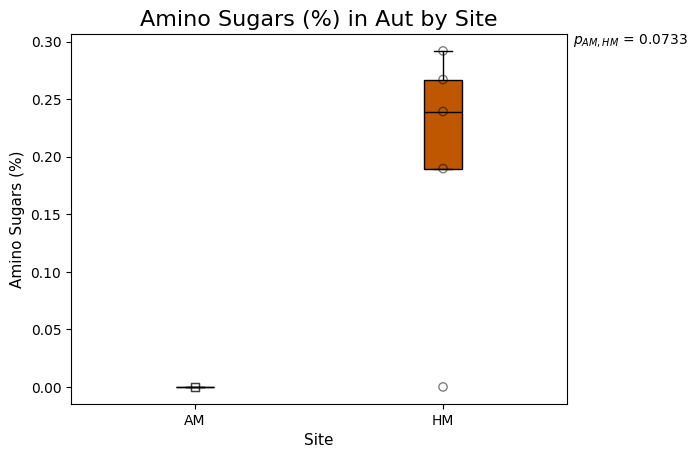

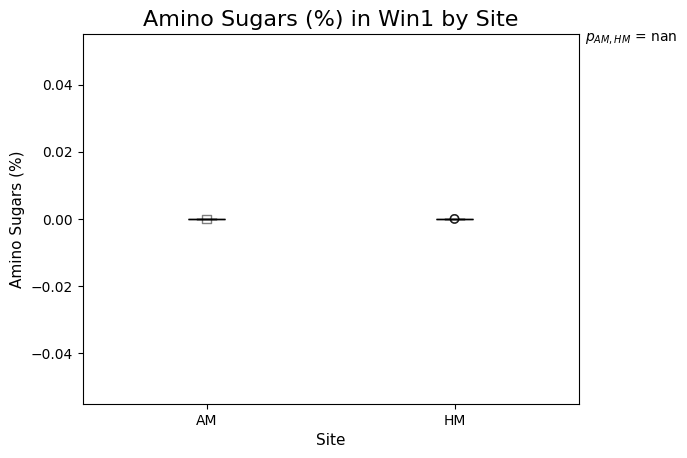

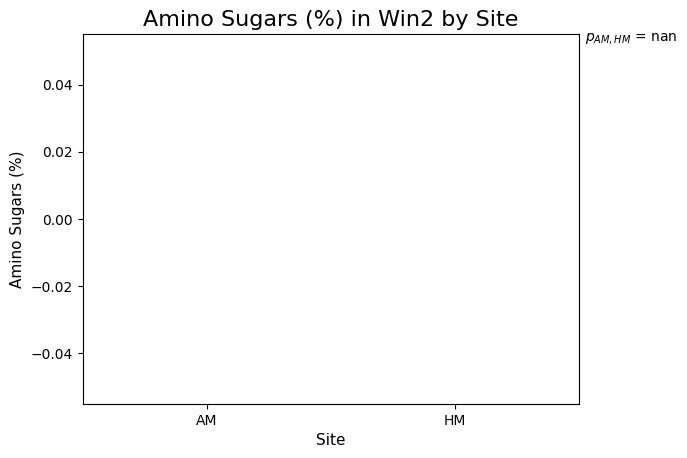

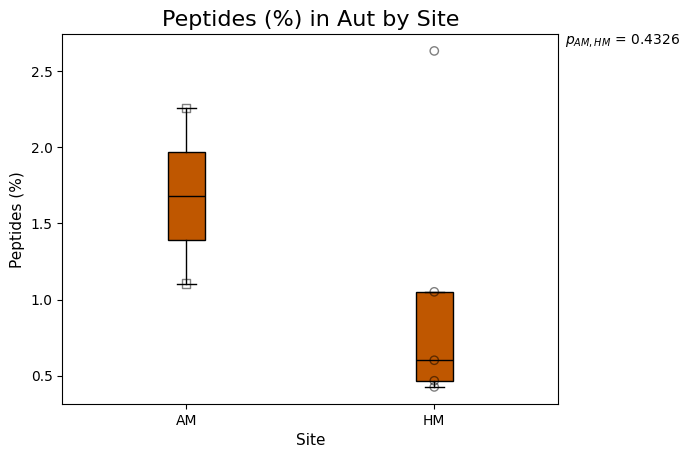

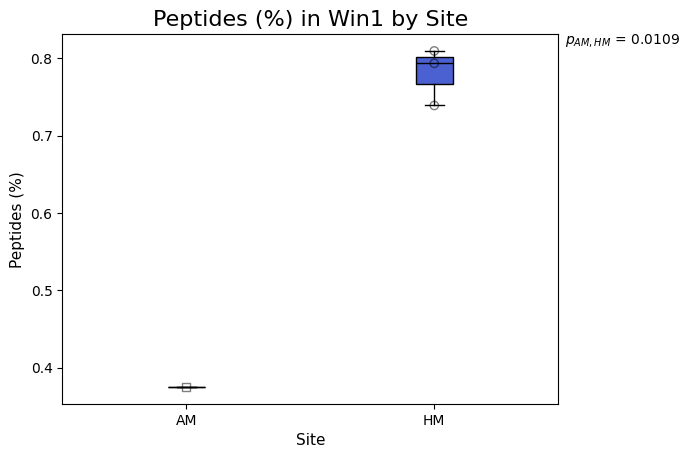

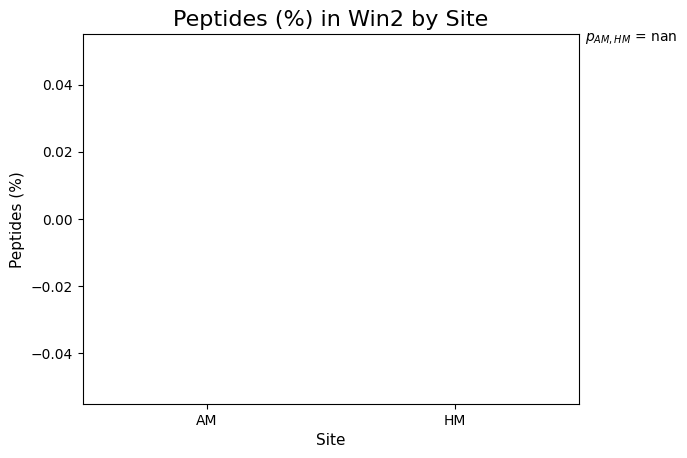

In [50]:
for v in variables_metadata:
    for s in seas_uniq:
        fig_box, ax_box = plt.subplots()
        ylabel = v.replace('_',' ').replace('(','[').replace(')',']').replace('-1','$^{-1}$').replace('avg','Average')
        if ylabel != ylabel.upper(): ylabel=' '.join([y.capitalize() for y in ylabel.split(' ')])
        for abbr in abbrs:
            ylabel = ylabel.replace(abbr.capitalize(),abbr.upper())
        if '%' in ylabel: ylabel = ylabel.replace('%','(%)')
        
        boxplot_anova(df_metadata,s,'season','Site',v,ax=ax_box,ylabel=ylabel,xlabel='Site',title=f'{ylabel} in {s} by Site',
                      colours=seasonal_colours[s],marker=[m_shape[s] for s in np.unique(df_metadata['Site'])])

        # site_boxplot(df_metadata,s,v,ax=ax_box,ylabel=ylabel,xlabel='Site',title=f'{ylabel} in {s} by Site')
        fig_box.savefig(f'anova_plots/by_site/{s}_{ylabel.replace(' ','_').replace('/','')}.svg', dpi = 600, facecolor = '#fff', bbox_inches='tight')
        # for i in range(len(df_metadata)):
        #     ax_box.scatter([i+1]*len(df_metadata[i]),df_metadata[i],zorder=-2,alpha=.5)